# Load in Data

In [1]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error

from pmdarima import auto_arima


In [2]:
# Read data in to dataframes
spy = pd.read_csv('etfs/SPY.csv')
dia = pd.read_csv('etfs/DIA.csv')
qqq = pd.read_csv('etfs/QQQ.csv')


# Change date column to datetime type
spy['Date'] = pd.to_datetime(spy['Date'])
dia['Date'] = pd.to_datetime(dia['Date'])
qqq['Date'] = pd.to_datetime(qqq['Date'])

# View amount of daily data
print(f'There are {spy.shape[0]} rows in SPY and {dia.shape[0]} DIA rows')
print('*'*100)
print(f'''The date range of SPY is {spy.index.min()} to {spy.index.max()} 
       \n DIA is {dia.index.values.min()} to {dia.index.max()}
       \n QQQ is {qqq.index.min()} to {qqq.index.max()}''')

There are 6843 rows in SPY and 5587 DIA rows
****************************************************************************************************
The date range of SPY is 0 to 6842 
       
 DIA is 0 to 5586
       
 QQQ is 0 to 5300


In [8]:
# Set Split point at 80% of total data leaving the other 20% to be validation data
split_time = round(spy['Adj Close'].index.max() * .8)

# Print out to verify
print('Total days in training set =',split_time,'\n' + '*'*100)

# Create split in data using split point
time_train = spy.index[:split_time]
x_train = spy['Adj Close'][:split_time]

# Print tail to verify you are getting the last 
print('Training Set')
print(x_train.tail())

# Create time span and validation data for validation data now
time_valid = spy.index[split_time:]
x_valid = spy['Adj Close'][split_time:]

# Print out head of validationdata set to see if it picks up right where train set leaves off
print('*'*100)
print('Validation Set')
print(x_valid.head())

Total days in training set = 5474 
****************************************************************************************************
Training Set
5469    166.888809
5470    168.859909
5471    170.499496
5472    173.877258
5473    172.640823
Name: Adj Close, dtype: float64
****************************************************************************************************
Validation Set
5474    174.647720
5475    175.991669
5476    175.749771
5477    177.765656
5478    177.496872
Name: Adj Close, dtype: float64


In [9]:
spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


Text(0.5, 1.0, 'SPY Daily Adjust Close Price')

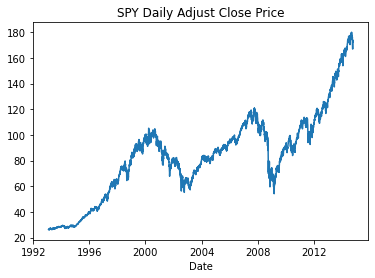

In [10]:
# Plot history of adjusted close price of SPY
sns.lineplot(x = spy['Date'][:split_time], y=x_train.values)
plt.title('SPY Daily Adjust Close Price')

## Create Train Test Split

### SPY Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just show of 7000 time steps. We know that our data is in days, so our data is just shy of 7000 daily observations. We need to separate out a training and validation set to see how our model holds up.

Using a traditional 80:20 train test split our train data will be from day 0 to day 5,474. Our validation set will be the remaining data.

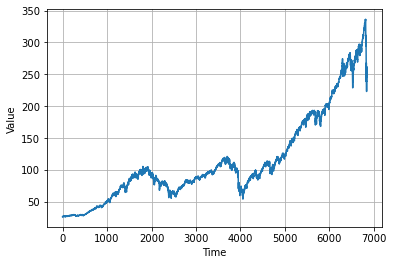

In [5]:
plot_series(time=spy.index,series=spy['Adj Close'])

In [7]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

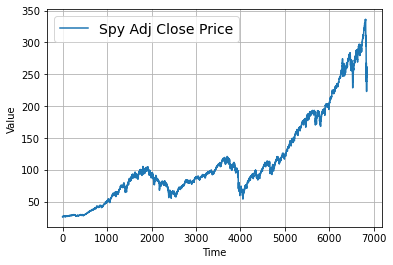

In [8]:
plot_series(time=spy.index,series=spy['Adj Close'], label = 'Spy Adj Close Price')

In [9]:
naive_forecast = spy['Adj Close'][split_time - 1:-1]

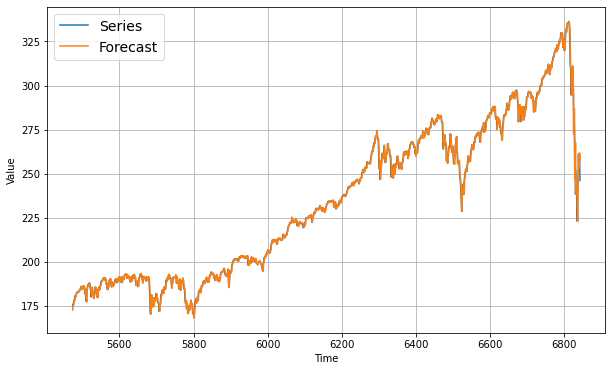

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

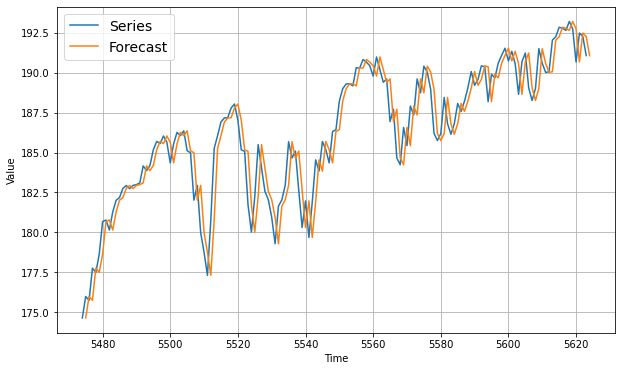

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

### Calculate Error in Naive Model

In [12]:
errors = naive_forecast.values - x_valid.values
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

1.5437803414723057

In [13]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
naive_forecast_mae

1.5437803414723057

In [14]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_valid.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_valid[:3].values))

[172.64082336 174.64772034 175.9916687 ]
[174.64772034 175.9916687  175.74977112]
****************************************************************************************************
[2.00689697 1.34394836 0.24189758]


### Add MAE score to our dictionary

In [15]:
model_mae_scores['Naive Forecast'] = naive_forecast_mae
model_mae_scores

{'Naive Forecast': 1.5437803414723057}

# Monthly Moving Average Model (20 Day MA)

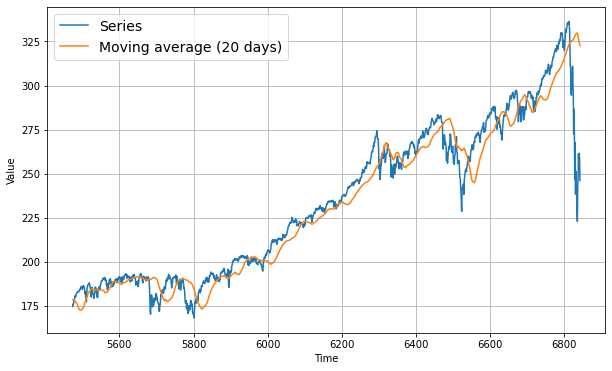

In [16]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = spy['Adj Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[split_time - window:x_valid.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg_forecast, label="Moving average (20 days)")

In [17]:
ma_20 = keras.metrics.mean_absolute_error(x_valid, moving_avg_forecast).numpy()

model_mae_scores['20 Day Moving Average'] = ma_20
model_mae_scores

{'Naive Forecast': 1.5437803414723057,
 '20 Day Moving Average': 8.162007501684373}

# Weekly Moving Average (5 day MA)

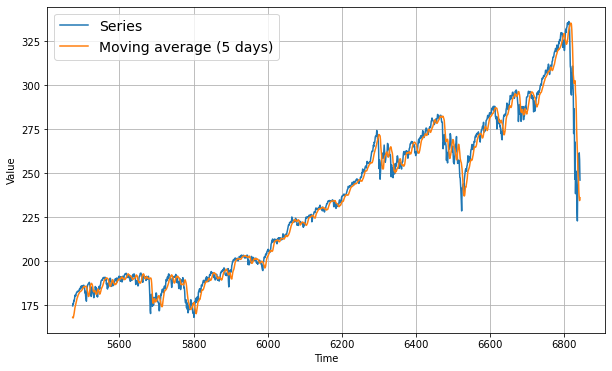

In [18]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = spy['Adj Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[split_time - window:x_valid.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg_forecast, label="Moving average (5 days)")

In [19]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_valid, moving_avg_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['5 Day Moving Average'] = ma_5
model_mae_scores

{'Naive Forecast': 1.5437803414723057,
 '20 Day Moving Average': 8.162007501684373,
 '5 Day Moving Average': 3.888705627129319}

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

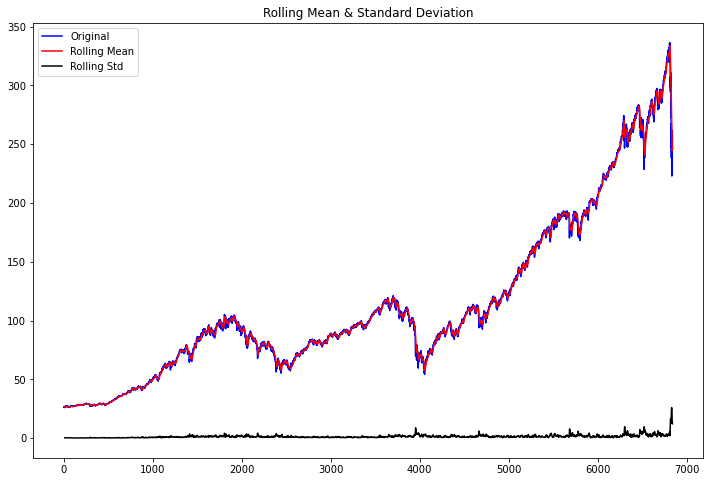

Results of Dickey-Fuller Test:
p-value = 0.9215. The series is likely non-stationary.
Test Statistic                   -0.327558
p-value                           0.921510
#Lags Used                       20.000000
Number of Observations Used    6822.000000
Critical Value (1%)              -3.431309
Critical Value (5%)              -2.861964
Critical Value (10%)             -2.566996
dtype: float64


In [99]:
test_stationarity(spy['Adj Close'])

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference.

In [100]:
# Get the difference of each Adj Close point
spy_close_diff_1 = spy['Adj Close'].diff()
spy_close_diff_1.dropna(inplace=True)

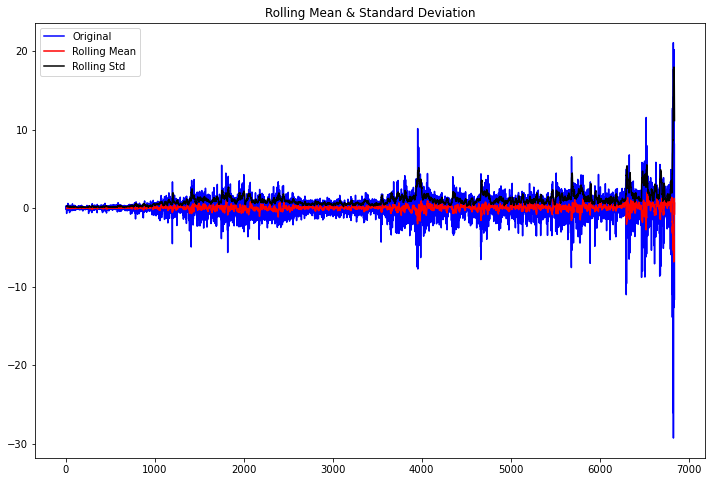

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.665179e+01
p-value                        1.601690e-29
#Lags Used                     2.000000e+01
Number of Observations Used    6.821000e+03
Critical Value (1%)           -3.431309e+00
Critical Value (5%)           -2.861964e+00
Critical Value (10%)          -2.566996e+00
dtype: float64


In [22]:
# Plot the spy Adj Close 1st order difference
test_stationarity(spy_close_diff_1)

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

### Step 3 Autocorrelation and Partial autocorrelation

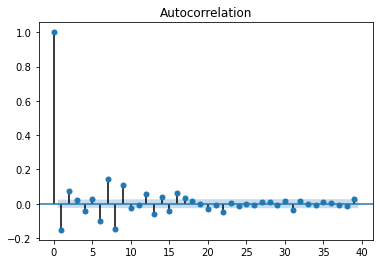

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(spy_close_diff_1)
plt.show()

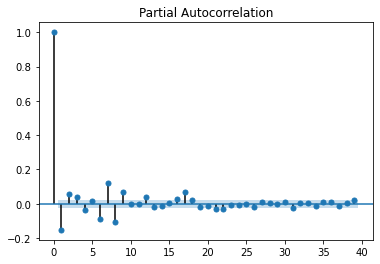

In [24]:
plot_pacf(spy_close_diff_1)
plt.show()

In [25]:
# Establish empty list for for-loop
spy_autocorr = []

# Loop through lag numbers to find the point with highest autocorrelation
for x in list(range(1,101)):
    spy_autocorr.append(spy_close_diff_1.autocorr(lag=x))

# Show the index of the point with the largest autocorrelation value
# 0 indexed so add 1 for correct number of lags
lags = spy_autocorr.index(max(spy_autocorr)) + 1 
print('The best performing lag is number {}'.format(lags))

The best performing lag is number 7


### Testing different arima models

In [106]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
spy_arima = ARIMA(x_train, order=(1,1,1))
spy_arima_fit = spy_arima.fit(disp=0)
print(spy_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 5473
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7799.712
Method:                       css-mle   S.D. of innovations              1.006
Date:                Thu, 27 Aug 2020   AIC                          15607.424
Time:                        15:36:15   BIC                          15633.854
Sample:                             1   HQIC                         15616.645
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0267      0.011      2.394      0.017       0.005       0.049
ar.L1.D.Adj Close     0.6229      0.084      7.403      0.000       0.458       0.788
ma.L1.D.Adj Close    -0.

NormaltestResult(statistic=876.0231547473588, pvalue=5.942770199323262e-191)
This distribution is not a normal distribution


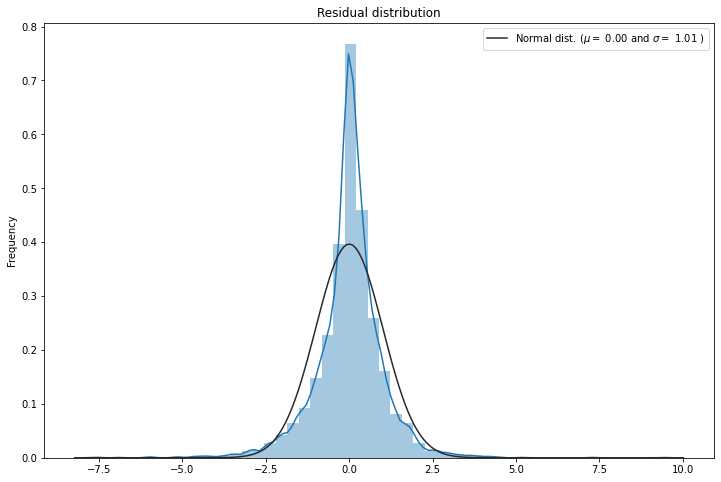

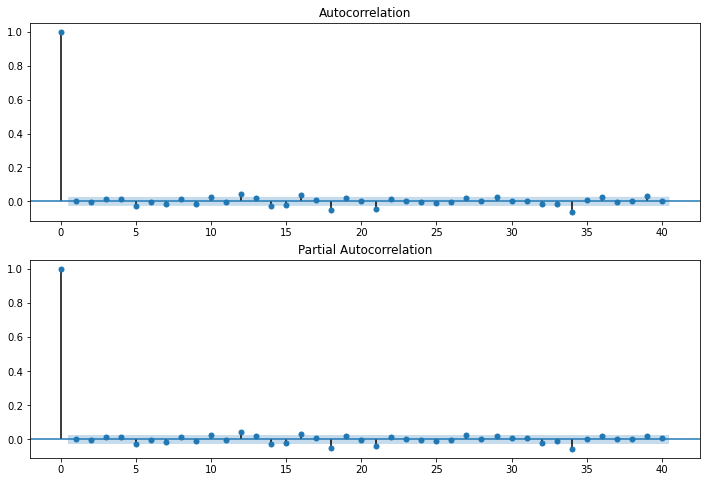

In [107]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = spy_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Step 4 Building the Arima Model and Forecasting

In [109]:
history = [x for x in x_train]
model_predictions = []
N_test_observations = len(x_valid)


for time_point in range(split_time,len(spy)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_valid[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(x_valid, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

C:\Users\blake\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing Mean Squared Error is 1.5397139038888477
Stored 'model_predictions' (list)


In [ ]:
# %store model_predictions
%store -r model_predictions
model_predictions[:5]

In [ ]:
#save model
model_fit.save('arima_715.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_715.pkl')

In [ ]:
# Calculate MAE
arima_mae = mean_absolute_error(x_valid, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

In [87]:
len(model_predictions)

101

In [31]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(x_valid.index, model_predictions, color='blue',label='Predicted Price')
plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SPY Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

NameError: name 'model_predictions' is not defined

In [32]:
# Find the Error in the ARIMA Model
arima_error = np.array(model_predictions).flatten() - x_valid

NameError: name 'model_predictions' is not defined

#### Show Error in model vs actual

In [33]:
plt.plot(x_valid.index, arima_error, color='blue',label='Predicted Price')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SPY Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

NameError: name 'arima_error' is not defined

# Deep Learning - RNN Model

### Seq to Vec RNN Model 

#### Data

In [21]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
keras = tf.keras

In [22]:
# Reshape values
x_train_values = x_train.values.reshape((len(x_train), 1))
x_valid_values = x_valid.values.reshape((len(x_valid), 1))

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))
x_valid_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_valid_scaler.fit_transform(x_valid_values)

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

#### Learning Rate

In [24]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Nadam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer= optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=125, callbacks=[lr_schedule])


Epoch 1/125
11/11 [==============================] - 2s 165ms/step - loss: 84.0118 - mae: 84.5118
Epoch 2/125
11/11 [==============================] - 2s 165ms/step - loss: 84.0102 - mae: 84.5102
Epoch 3/125
11/11 [==============================] - 2s 166ms/step - loss: 84.0082 - mae: 84.5082
Epoch 4/125
11/11 [==============================] - 2s 163ms/step - loss: 84.0059 - mae: 84.5059
Epoch 5/125
11/11 [==============================] - 2s 165ms/step - loss: 84.0033 - mae: 84.5033
Epoch 6/125
11/11 [==============================] - 2s 161ms/step - loss: 84.0003 - mae: 84.5003
Epoch 7/125
11/11 [==============================] - 2s 166ms/step - loss: 83.9970 - mae: 84.4970
Epoch 8/125
11/11 [==============================] - 2s 162ms/step - loss: 83.9933 - mae: 84.4933
Epoch 9/125
11/11 [==============================] - 2s 165ms/step - loss: 83.9892 - mae: 84.4892
Epoch 10/125
11/11 [==============================] - 2s 162ms/step - loss: 83.9845 - mae: 84.4845
Epoch 11/125
11/11 

11/11 [==============================] - 2s 162ms/step - loss: 56.8331 - mae: 57.3283
Epoch 84/125
11/11 [==============================] - 2s 165ms/step - loss: 55.1789 - mae: 55.6687
Epoch 85/125
11/11 [==============================] - 2s 162ms/step - loss: 53.5945 - mae: 54.0928
Epoch 86/125
11/11 [==============================] - 2s 166ms/step - loss: 51.9249 - mae: 52.4237
Epoch 87/125
11/11 [==============================] - 2s 164ms/step - loss: 50.1351 - mae: 50.6336
Epoch 88/125
11/11 [==============================] - 2s 166ms/step - loss: 48.2267 - mae: 48.7245
Epoch 89/125
11/11 [==============================] - 2s 165ms/step - loss: 46.1975 - mae: 46.6958
Epoch 90/125
11/11 [==============================] - 2s 166ms/step - loss: 43.8931 - mae: 44.3896
Epoch 91/125
11/11 [==============================] - 2s 163ms/step - loss: 41.4342 - mae: 41.9312
Epoch 92/125
11/11 [==============================] - 2s 167ms/step - loss: 38.0173 - mae: 38.5139
Epoch 93/125
11/11 [===

(1e-07, 1.0, 0.0, 100.0)

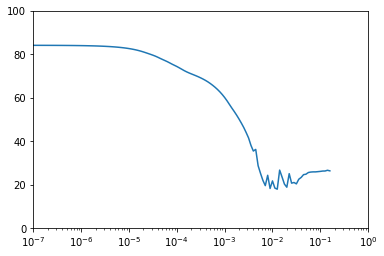

In [25]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, 100])

#### Model Train

In [26]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)
valid_set = window_dataset(x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# # Set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-3)

#compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
     11/Unknown - 2s 164ms/step - loss: 79.8359 - mae: 80.3359INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 4s 342ms/step - loss: 79.8359 - mae: 80.3359 - val_loss: 228.3918 - val_mae: 228.8918
Epoch 2/1000
11/11 [==============================] - 4s 327ms/step - loss: 73.6044 - mae: 74.1044 - val_loss: 224.9036 - val_mae: 225.4036
Epoch 3/1000
11/11 [==============================] - 4s 333ms/step - loss: 70.9748 - mae: 71.4748 - val_loss: 222.6761 - val_mae: 223.1761
Epoch 4/1000
11/11 [==============================] - 4s 351ms/step - loss: 69.0954 - mae: 69.5954 - val_loss: 221.3035 - val_mae: 221.8035
Epoch 5/1000
11/11 [==============================] - 4s 323ms/step - loss: 67.7989 - mae: 68.2989 - val_loss: 220.0579 - val_mae: 220.5579
Epoch 6/1000
11/11 [==============================] - 4s 327ms/step - loss: 66.5711 - mae: 67.0711 - val_loss: 218.8464 - val_mae: 219.3464
Epoch 7/1000
11/11 [======================

Epoch 31/1000
11/11 [==============================] - 5s 430ms/step - loss: 43.9010 - mae: 44.3981 - val_loss: 193.1235 - val_mae: 193.6235
Epoch 32/1000
11/11 [==============================] - 4s 381ms/step - loss: 43.2810 - mae: 43.7802 - val_loss: 192.2414 - val_mae: 192.7414
Epoch 33/1000
11/11 [==============================] - 4s 381ms/step - loss: 42.6585 - mae: 43.1576 - val_loss: 191.3671 - val_mae: 191.8671
Epoch 34/1000
11/11 [==============================] - 4s 377ms/step - loss: 41.8523 - mae: 42.3510 - val_loss: 190.4945 - val_mae: 190.9945
Epoch 35/1000
11/11 [==============================] - 4s 376ms/step - loss: 40.3798 - mae: 40.8772 - val_loss: 189.5628 - val_mae: 190.0628
Epoch 36/1000
11/11 [==============================] - 5s 431ms/step - loss: 39.1271 - mae: 39.6192 - val_loss: 188.5566 - val_mae: 189.0566
Epoch 37/1000
11/11 [==============================] - 4s 372ms/step - loss: 38.1570 - mae: 38.6476 - val_loss: 187.5850 - val_mae: 188.0850
Epoch 38/1000

Epoch 61/1000
11/11 [==============================] - 4s 366ms/step - loss: 20.1950 - mae: 20.6640 - val_loss: 164.4860 - val_mae: 164.9860
Epoch 62/1000
11/11 [==============================] - 4s 354ms/step - loss: 19.6043 - mae: 20.0697 - val_loss: 163.6313 - val_mae: 164.1313
Epoch 63/1000
11/11 [==============================] - 4s 405ms/step - loss: 19.0423 - mae: 19.5056 - val_loss: 162.7888 - val_mae: 163.2888
Epoch 64/1000
11/11 [==============================] - 4s 382ms/step - loss: 18.6267 - mae: 19.0964 - val_loss: 161.9588 - val_mae: 162.4588
Epoch 65/1000
11/11 [==============================] - 4s 380ms/step - loss: 18.0122 - mae: 18.4783 - val_loss: 161.1361 - val_mae: 161.6361
Epoch 66/1000
11/11 [==============================] - 4s 378ms/step - loss: 17.4811 - mae: 17.9403 - val_loss: 160.3225 - val_mae: 160.8225
Epoch 67/1000
11/11 [==============================] - 5s 410ms/step - loss: 16.9634 - mae: 17.4180 - val_loss: 159.5076 - val_mae: 160.0076
Epoch 68/1000

Epoch 91/1000
11/11 [==============================] - 5s 421ms/step - loss: 9.3644 - mae: 9.8090 - val_loss: 143.6926 - val_mae: 144.1926
Epoch 92/1000
11/11 [==============================] - 5s 414ms/step - loss: 9.1687 - mae: 9.6179 - val_loss: 143.1726 - val_mae: 143.6726
Epoch 93/1000
11/11 [==============================] - 5s 418ms/step - loss: 8.7843 - mae: 9.2102 - val_loss: 142.6594 - val_mae: 143.1594
Epoch 94/1000
11/11 [==============================] - 5s 410ms/step - loss: 8.6893 - mae: 9.1209 - val_loss: 142.1620 - val_mae: 142.6620
Epoch 95/1000
11/11 [==============================] - 5s 455ms/step - loss: 8.6084 - mae: 9.0531 - val_loss: 141.6745 - val_mae: 142.1745
Epoch 96/1000
11/11 [==============================] - 4s 400ms/step - loss: 8.4110 - mae: 8.8507 - val_loss: 141.2030 - val_mae: 141.7030
Epoch 97/1000
11/11 [==============================] - 4s 398ms/step - loss: 8.2580 - mae: 8.6953 - val_loss: 140.7349 - val_mae: 141.2349
Epoch 98/1000
11/11 [======

11/11 [==============================] - 4s 388ms/step - loss: 5.8198 - mae: 6.2506 - val_loss: 131.2287 - val_mae: 131.7287
Epoch 122/1000
11/11 [==============================] - 5s 441ms/step - loss: 5.5621 - mae: 5.9712 - val_loss: 130.8759 - val_mae: 131.3759
Epoch 123/1000
11/11 [==============================] - 4s 407ms/step - loss: 5.6142 - mae: 6.0356 - val_loss: 130.5444 - val_mae: 131.0444
Epoch 124/1000
11/11 [==============================] - 5s 411ms/step - loss: 5.4441 - mae: 5.8560 - val_loss: 130.2098 - val_mae: 130.7098
Epoch 125/1000
11/11 [==============================] - 4s 409ms/step - loss: 5.4299 - mae: 5.8517 - val_loss: 129.8798 - val_mae: 130.3798
Epoch 126/1000
11/11 [==============================] - 4s 406ms/step - loss: 5.3889 - mae: 5.8105 - val_loss: 129.5505 - val_mae: 130.0505
Epoch 127/1000
11/11 [==============================] - 5s 428ms/step - loss: 5.1495 - mae: 5.5444 - val_loss: 129.2263 - val_mae: 129.7263
Epoch 128/1000
11/11 [=============

11/11 [==============================] - 4s 406ms/step - loss: 4.1827 - mae: 4.5876 - val_loss: 122.6537 - val_mae: 123.1537
Epoch 152/1000
11/11 [==============================] - 4s 406ms/step - loss: 4.2486 - mae: 4.6660 - val_loss: 122.4203 - val_mae: 122.9203
Epoch 153/1000
11/11 [==============================] - 4s 396ms/step - loss: 4.3325 - mae: 4.7703 - val_loss: 122.1909 - val_mae: 122.6909
Epoch 154/1000
11/11 [==============================] - 5s 445ms/step - loss: 4.1082 - mae: 4.5162 - val_loss: 121.9669 - val_mae: 122.4669
Epoch 155/1000
11/11 [==============================] - 4s 402ms/step - loss: 4.0500 - mae: 4.4503 - val_loss: 121.7293 - val_mae: 122.2293
Epoch 156/1000
11/11 [==============================] - 4s 408ms/step - loss: 4.0827 - mae: 4.4891 - val_loss: 121.4989 - val_mae: 121.9989
Epoch 157/1000
11/11 [==============================] - 4s 400ms/step - loss: 4.0156 - mae: 4.4204 - val_loss: 121.2755 - val_mae: 121.7755
Epoch 158/1000
11/11 [=============

11/11 [==============================] - 5s 425ms/step - loss: 3.5179 - mae: 3.9193 - val_loss: 116.2523 - val_mae: 116.7523
Epoch 182/1000
11/11 [==============================] - 5s 416ms/step - loss: 3.3716 - mae: 3.7568 - val_loss: 116.0458 - val_mae: 116.5458
Epoch 183/1000
11/11 [==============================] - 5s 415ms/step - loss: 3.4838 - mae: 3.8895 - val_loss: 115.8542 - val_mae: 116.3542
Epoch 184/1000
11/11 [==============================] - 5s 415ms/step - loss: 3.3777 - mae: 3.7743 - val_loss: 115.6408 - val_mae: 116.1408
Epoch 185/1000
11/11 [==============================] - 5s 410ms/step - loss: 3.3543 - mae: 3.7507 - val_loss: 115.4584 - val_mae: 115.9584
Epoch 186/1000
11/11 [==============================] - 5s 454ms/step - loss: 3.3360 - mae: 3.7275 - val_loss: 115.2491 - val_mae: 115.7491
Epoch 187/1000
11/11 [==============================] - 5s 422ms/step - loss: 3.3102 - mae: 3.6965 - val_loss: 115.0522 - val_mae: 115.5522
Epoch 188/1000
11/11 [=============

11/11 [==============================] - 4s 396ms/step - loss: 2.8718 - mae: 3.2588 - val_loss: 110.4533 - val_mae: 110.9533
Epoch 212/1000
11/11 [==============================] - 4s 381ms/step - loss: 2.8861 - mae: 3.2757 - val_loss: 110.2780 - val_mae: 110.7780
Epoch 213/1000
11/11 [==============================] - 5s 434ms/step - loss: 2.9467 - mae: 3.3496 - val_loss: 110.0912 - val_mae: 110.5912
Epoch 214/1000
11/11 [==============================] - 4s 396ms/step - loss: 2.8368 - mae: 3.2222 - val_loss: 109.8795 - val_mae: 110.3795
Epoch 215/1000
11/11 [==============================] - 4s 398ms/step - loss: 2.8444 - mae: 3.2297 - val_loss: 109.6848 - val_mae: 110.1848
Epoch 216/1000
11/11 [==============================] - 4s 399ms/step - loss: 2.8602 - mae: 3.2596 - val_loss: 109.4936 - val_mae: 109.9936
Epoch 217/1000
11/11 [==============================] - 4s 396ms/step - loss: 2.7433 - mae: 3.1305 - val_loss: 109.3211 - val_mae: 109.8211
Epoch 218/1000
11/11 [=============

11/11 [==============================] - 5s 448ms/step - loss: 2.4968 - mae: 2.8933 - val_loss: 104.7228 - val_mae: 105.2228
Epoch 242/1000
11/11 [==============================] - 4s 406ms/step - loss: 2.3967 - mae: 2.7766 - val_loss: 104.5205 - val_mae: 105.0205
Epoch 243/1000
11/11 [==============================] - 5s 412ms/step - loss: 2.3347 - mae: 2.7101 - val_loss: 104.3474 - val_mae: 104.8474
Epoch 244/1000
11/11 [==============================] - 4s 390ms/step - loss: 2.3206 - mae: 2.6970 - val_loss: 104.1538 - val_mae: 104.6538
Epoch 245/1000
11/11 [==============================] - 5s 438ms/step - loss: 2.4910 - mae: 2.8984 - val_loss: 103.9738 - val_mae: 104.4738
Epoch 246/1000
11/11 [==============================] - 4s 394ms/step - loss: 2.2289 - mae: 2.5885 - val_loss: 103.7524 - val_mae: 104.2524
Epoch 247/1000
11/11 [==============================] - 4s 393ms/step - loss: 2.3668 - mae: 2.7557 - val_loss: 103.5825 - val_mae: 104.0825
Epoch 248/1000
11/11 [=============

11/11 [==============================] - 4s 384ms/step - loss: 2.0117 - mae: 2.3928 - val_loss: 99.1132 - val_mae: 99.6132
Epoch 272/1000
11/11 [==============================] - 5s 432ms/step - loss: 1.8624 - mae: 2.2167 - val_loss: 98.9078 - val_mae: 99.4078
Epoch 273/1000
11/11 [==============================] - 4s 402ms/step - loss: 1.9742 - mae: 2.3583 - val_loss: 98.7076 - val_mae: 99.2076
Epoch 274/1000
11/11 [==============================] - 4s 407ms/step - loss: 1.9863 - mae: 2.3692 - val_loss: 98.5508 - val_mae: 99.0508
Epoch 275/1000
11/11 [==============================] - 4s 397ms/step - loss: 1.9421 - mae: 2.3260 - val_loss: 98.3538 - val_mae: 98.8538
Epoch 276/1000
11/11 [==============================] - 4s 358ms/step - loss: 1.7935 - mae: 2.1460 - val_loss: 98.1505 - val_mae: 98.6505
Epoch 277/1000
11/11 [==============================] - 4s 399ms/step - loss: 1.8403 - mae: 2.2005 - val_loss: 97.9798 - val_mae: 98.4798
Epoch 278/1000
11/11 [===========================

11/11 [==============================] - 4s 405ms/step - loss: 1.6709 - mae: 2.0530 - val_loss: 93.7236 - val_mae: 94.2236
Epoch 302/1000
11/11 [==============================] - 4s 402ms/step - loss: 1.5393 - mae: 1.8962 - val_loss: 93.5451 - val_mae: 94.0451
Epoch 303/1000
11/11 [==============================] - 4s 405ms/step - loss: 1.7414 - mae: 2.1403 - val_loss: 93.3923 - val_mae: 93.8923
Epoch 304/1000
11/11 [==============================] - 5s 431ms/step - loss: 1.5767 - mae: 1.9560 - val_loss: 93.2091 - val_mae: 93.7091
Epoch 305/1000
11/11 [==============================] - 4s 397ms/step - loss: 1.4990 - mae: 1.8577 - val_loss: 93.0473 - val_mae: 93.5473
Epoch 306/1000
11/11 [==============================] - 4s 399ms/step - loss: 1.4595 - mae: 1.8022 - val_loss: 92.8797 - val_mae: 93.3797
Epoch 307/1000
11/11 [==============================] - 4s 399ms/step - loss: 1.6276 - mae: 2.0144 - val_loss: 92.7141 - val_mae: 93.2141
Epoch 308/1000
11/11 [===========================

11/11 [==============================] - 5s 426ms/step - loss: 1.3920 - mae: 1.7725 - val_loss: 88.9279 - val_mae: 89.4279
Epoch 332/1000
11/11 [==============================] - 4s 398ms/step - loss: 1.4562 - mae: 1.8517 - val_loss: 88.7845 - val_mae: 89.2845
Epoch 333/1000
11/11 [==============================] - 4s 393ms/step - loss: 1.3961 - mae: 1.7810 - val_loss: 88.6202 - val_mae: 89.1202
Epoch 334/1000
11/11 [==============================] - 4s 395ms/step - loss: 1.3287 - mae: 1.7003 - val_loss: 88.4860 - val_mae: 88.9860
Epoch 335/1000
11/11 [==============================] - 4s 388ms/step - loss: 1.3358 - mae: 1.7070 - val_loss: 88.3557 - val_mae: 88.8557
Epoch 336/1000
11/11 [==============================] - 5s 434ms/step - loss: 1.3251 - mae: 1.6870 - val_loss: 88.1995 - val_mae: 88.6995
Epoch 337/1000
11/11 [==============================] - 4s 395ms/step - loss: 1.3196 - mae: 1.6860 - val_loss: 88.0626 - val_mae: 88.5626
Epoch 338/1000
11/11 [===========================

11/11 [==============================] - 4s 406ms/step - loss: 1.1562 - mae: 1.5308 - val_loss: 84.4894 - val_mae: 84.9894
Epoch 362/1000
11/11 [==============================] - 4s 391ms/step - loss: 1.0961 - mae: 1.4542 - val_loss: 84.3540 - val_mae: 84.8540
Epoch 363/1000
11/11 [==============================] - 5s 443ms/step - loss: 1.1361 - mae: 1.5001 - val_loss: 84.1983 - val_mae: 84.6983
Epoch 364/1000
11/11 [==============================] - 4s 407ms/step - loss: 1.1997 - mae: 1.5879 - val_loss: 84.0560 - val_mae: 84.5560
Epoch 365/1000
11/11 [==============================] - 5s 411ms/step - loss: 1.1188 - mae: 1.4861 - val_loss: 83.8718 - val_mae: 84.3718
Epoch 366/1000
11/11 [==============================] - 4s 409ms/step - loss: 1.1403 - mae: 1.5092 - val_loss: 83.7482 - val_mae: 84.2482
Epoch 367/1000
11/11 [==============================] - 4s 409ms/step - loss: 1.1258 - mae: 1.5009 - val_loss: 83.5916 - val_mae: 84.0916
Epoch 368/1000
11/11 [===========================

11/11 [==============================] - 4s 404ms/step - loss: 0.8501 - mae: 1.1964 - val_loss: 80.1099 - val_mae: 80.6099
Epoch 392/1000
11/11 [==============================] - 4s 399ms/step - loss: 1.0030 - mae: 1.3813 - val_loss: 79.9940 - val_mae: 80.4940
Epoch 393/1000
11/11 [==============================] - 4s 407ms/step - loss: 0.9993 - mae: 1.3757 - val_loss: 79.8611 - val_mae: 80.3611
Epoch 394/1000
11/11 [==============================] - 4s 390ms/step - loss: 0.9122 - mae: 1.2698 - val_loss: 79.7445 - val_mae: 80.2445
Epoch 395/1000
11/11 [==============================] - 5s 429ms/step - loss: 0.9304 - mae: 1.2988 - val_loss: 79.5917 - val_mae: 80.0917
Epoch 396/1000
11/11 [==============================] - 4s 400ms/step - loss: 0.8944 - mae: 1.2505 - val_loss: 79.4660 - val_mae: 79.9660
Epoch 397/1000
11/11 [==============================] - 4s 404ms/step - loss: 0.8711 - mae: 1.2310 - val_loss: 79.3305 - val_mae: 79.8305
Epoch 398/1000
11/11 [===========================

11/11 [==============================] - 4s 383ms/step - loss: 0.8121 - mae: 1.1654 - val_loss: 76.4832 - val_mae: 76.9832
Epoch 422/1000
11/11 [==============================] - 5s 424ms/step - loss: 0.7553 - mae: 1.0964 - val_loss: 76.3692 - val_mae: 76.8692
Epoch 423/1000
11/11 [==============================] - 4s 372ms/step - loss: 0.8749 - mae: 1.2613 - val_loss: 76.2694 - val_mae: 76.7694
Epoch 424/1000
11/11 [==============================] - 4s 372ms/step - loss: 0.7807 - mae: 1.1434 - val_loss: 76.1277 - val_mae: 76.6277
Epoch 425/1000
11/11 [==============================] - 4s 379ms/step - loss: 0.8197 - mae: 1.1844 - val_loss: 76.0395 - val_mae: 76.5395
Epoch 426/1000
11/11 [==============================] - 4s 371ms/step - loss: 0.8264 - mae: 1.2022 - val_loss: 75.9050 - val_mae: 76.4050
Epoch 427/1000
11/11 [==============================] - 5s 415ms/step - loss: 0.8035 - mae: 1.1690 - val_loss: 75.7689 - val_mae: 76.2689
Epoch 428/1000
11/11 [===========================

11/11 [==============================] - 4s 386ms/step - loss: 0.7297 - mae: 1.0914 - val_loss: 73.2678 - val_mae: 73.7678
Epoch 452/1000
11/11 [==============================] - 4s 388ms/step - loss: 0.8121 - mae: 1.1987 - val_loss: 73.1690 - val_mae: 73.6690
Epoch 453/1000
11/11 [==============================] - 4s 376ms/step - loss: 0.6323 - mae: 0.9839 - val_loss: 73.0757 - val_mae: 73.5757
Epoch 454/1000
11/11 [==============================] - 5s 427ms/step - loss: 0.7379 - mae: 1.1116 - val_loss: 73.0039 - val_mae: 73.5039
Epoch 455/1000
11/11 [==============================] - 4s 399ms/step - loss: 0.6762 - mae: 1.0344 - val_loss: 72.8844 - val_mae: 73.3844
Epoch 456/1000
11/11 [==============================] - 4s 397ms/step - loss: 0.6466 - mae: 0.9837 - val_loss: 72.8143 - val_mae: 73.3143
Epoch 457/1000
11/11 [==============================] - 4s 390ms/step - loss: 0.7517 - mae: 1.1248 - val_loss: 72.7003 - val_mae: 73.2003
Epoch 458/1000
11/11 [===========================

11/11 [==============================] - 5s 463ms/step - loss: 0.6441 - mae: 1.0012 - val_loss: 70.7654 - val_mae: 71.2654
Epoch 482/1000
11/11 [==============================] - 5s 434ms/step - loss: 0.5988 - mae: 0.9546 - val_loss: 70.6935 - val_mae: 71.1935
Epoch 483/1000
11/11 [==============================] - 5s 429ms/step - loss: 0.5647 - mae: 0.9036 - val_loss: 70.5879 - val_mae: 71.0879
Epoch 484/1000
11/11 [==============================] - 5s 434ms/step - loss: 0.6480 - mae: 1.0049 - val_loss: 70.5382 - val_mae: 71.0382
Epoch 485/1000
11/11 [==============================] - 5s 425ms/step - loss: 0.7107 - mae: 1.0839 - val_loss: 70.4381 - val_mae: 70.9381
Epoch 486/1000
11/11 [==============================] - 5s 477ms/step - loss: 0.6656 - mae: 1.0403 - val_loss: 70.3969 - val_mae: 70.8969
Epoch 487/1000
11/11 [==============================] - 5s 415ms/step - loss: 0.6157 - mae: 0.9602 - val_loss: 70.3065 - val_mae: 70.8064
Epoch 488/1000
11/11 [===========================

11/11 [==============================] - 5s 411ms/step - loss: 0.5370 - mae: 0.8804 - val_loss: 68.6294 - val_mae: 69.1294
Epoch 512/1000
11/11 [==============================] - 5s 414ms/step - loss: 0.5899 - mae: 0.9460 - val_loss: 68.5946 - val_mae: 69.0945
Epoch 513/1000
11/11 [==============================] - 5s 458ms/step - loss: 0.6787 - mae: 1.0544 - val_loss: 68.5071 - val_mae: 69.0070
Epoch 514/1000
11/11 [==============================] - 5s 411ms/step - loss: 0.5282 - mae: 0.8652 - val_loss: 68.4689 - val_mae: 68.9689
Epoch 515/1000
11/11 [==============================] - 4s 407ms/step - loss: 0.5990 - mae: 0.9435 - val_loss: 68.3639 - val_mae: 68.8639
Epoch 516/1000
11/11 [==============================] - 4s 405ms/step - loss: 0.6519 - mae: 1.0321 - val_loss: 68.3175 - val_mae: 68.8174
Epoch 517/1000
11/11 [==============================] - 5s 447ms/step - loss: 0.5890 - mae: 0.9491 - val_loss: 68.2374 - val_mae: 68.7374
Epoch 518/1000
11/11 [===========================

11/11 [==============================] - 4s 395ms/step - loss: 0.5673 - mae: 0.9225 - val_loss: 66.6152 - val_mae: 67.1147
Epoch 542/1000
11/11 [==============================] - 4s 398ms/step - loss: 0.4965 - mae: 0.8382 - val_loss: 66.5438 - val_mae: 67.0433
Epoch 543/1000
11/11 [==============================] - 4s 389ms/step - loss: 0.5895 - mae: 0.9471 - val_loss: 66.4902 - val_mae: 66.9897
Epoch 544/1000
11/11 [==============================] - 5s 418ms/step - loss: 0.5267 - mae: 0.8819 - val_loss: 66.4092 - val_mae: 66.9087
Epoch 545/1000
11/11 [==============================] - 4s 392ms/step - loss: 0.5856 - mae: 0.9365 - val_loss: 66.3777 - val_mae: 66.8772
Epoch 546/1000
11/11 [==============================] - 4s 396ms/step - loss: 0.7416 - mae: 1.1291 - val_loss: 66.3242 - val_mae: 66.8236
Epoch 547/1000
11/11 [==============================] - 4s 395ms/step - loss: 0.4941 - mae: 0.8357 - val_loss: 66.2640 - val_mae: 66.7633
Epoch 548/1000
11/11 [===========================

11/11 [==============================] - 5s 426ms/step - loss: 0.5460 - mae: 0.9072 - val_loss: 64.8552 - val_mae: 65.3535
Epoch 572/1000
11/11 [==============================] - 4s 397ms/step - loss: 0.4795 - mae: 0.8198 - val_loss: 64.7690 - val_mae: 65.2672
Epoch 573/1000
11/11 [==============================] - 4s 399ms/step - loss: 0.5496 - mae: 0.9161 - val_loss: 64.7546 - val_mae: 65.2529
Epoch 574/1000
11/11 [==============================] - 4s 406ms/step - loss: 0.6367 - mae: 1.0182 - val_loss: 64.6862 - val_mae: 65.1844
Epoch 575/1000
11/11 [==============================] - 4s 380ms/step - loss: 0.5495 - mae: 0.9218 - val_loss: 64.6428 - val_mae: 65.1410
Epoch 576/1000
11/11 [==============================] - 5s 424ms/step - loss: 0.5749 - mae: 0.9442 - val_loss: 64.6090 - val_mae: 65.1072
Epoch 577/1000
11/11 [==============================] - 4s 402ms/step - loss: 0.5203 - mae: 0.8621 - val_loss: 64.5050 - val_mae: 65.0033
Epoch 578/1000
11/11 [===========================

11/11 [==============================] - 4s 405ms/step - loss: 0.5665 - mae: 0.9307 - val_loss: 63.4480 - val_mae: 63.9472
Epoch 602/1000
11/11 [==============================] - 4s 400ms/step - loss: 0.4615 - mae: 0.8014 - val_loss: 63.4276 - val_mae: 63.9269
Epoch 603/1000
11/11 [==============================] - 5s 443ms/step - loss: 0.5480 - mae: 0.9074 - val_loss: 63.3885 - val_mae: 63.8877
Epoch 604/1000
11/11 [==============================] - 5s 410ms/step - loss: 0.5157 - mae: 0.8745 - val_loss: 63.3672 - val_mae: 63.8664
Epoch 605/1000
11/11 [==============================] - 5s 414ms/step - loss: 0.4899 - mae: 0.8454 - val_loss: 63.3178 - val_mae: 63.8170
Epoch 606/1000
11/11 [==============================] - 5s 409ms/step - loss: 0.4526 - mae: 0.7861 - val_loss: 63.3100 - val_mae: 63.8089
Epoch 607/1000
11/11 [==============================] - 4s 398ms/step - loss: 0.5678 - mae: 0.9333 - val_loss: 63.2330 - val_mae: 63.7321
Epoch 608/1000
11/11 [===========================

Epoch 634/1000
11/11 [==============================] - 4s 378ms/step - loss: 0.4465 - mae: 0.7761 - val_loss: 62.4885 - val_mae: 62.9877
Epoch 635/1000
11/11 [==============================] - 5s 433ms/step - loss: 0.4622 - mae: 0.7963 - val_loss: 62.4469 - val_mae: 62.9462
Epoch 636/1000
11/11 [==============================] - 4s 399ms/step - loss: 0.4376 - mae: 0.7721 - val_loss: 62.4281 - val_mae: 62.9271
Epoch 637/1000
11/11 [==============================] - 4s 398ms/step - loss: 0.4325 - mae: 0.7656 - val_loss: 62.3868 - val_mae: 62.8858
Epoch 638/1000
11/11 [==============================] - 3s 267ms/step - loss: 0.5454 - mae: 0.9089 - val_loss: 62.3885 - val_mae: 62.8869
Epoch 639/1000
11/11 [==============================] - 4s 396ms/step - loss: 0.4830 - mae: 0.8302 - val_loss: 62.3629 - val_mae: 62.8616
Epoch 640/1000
11/11 [==============================] - 4s 397ms/step - loss: 0.4181 - mae: 0.7505 - val_loss: 62.3152 - val_mae: 62.8147
Epoch 641/1000
11/11 [============

11/11 [==============================] - 4s 384ms/step - loss: 0.4372 - mae: 0.7742 - val_loss: 61.7049 - val_mae: 62.2043
Epoch 668/1000
11/11 [==============================] - 3s 264ms/step - loss: 0.4580 - mae: 0.7913 - val_loss: 61.7142 - val_mae: 62.2133
Epoch 669/1000
11/11 [==============================] - 5s 456ms/step - loss: 0.5614 - mae: 0.9219 - val_loss: 61.6774 - val_mae: 62.1766
Epoch 670/1000
11/11 [==============================] - 3s 264ms/step - loss: 0.4057 - mae: 0.7364 - val_loss: 61.6797 - val_mae: 62.1783
Epoch 671/1000
11/11 [==============================] - 4s 396ms/step - loss: 0.4680 - mae: 0.8070 - val_loss: 61.6499 - val_mae: 62.1484
Epoch 672/1000
11/11 [==============================] - 4s 403ms/step - loss: 0.4887 - mae: 0.8485 - val_loss: 61.6083 - val_mae: 62.1065
Epoch 673/1000
11/11 [==============================] - 3s 264ms/step - loss: 0.4548 - mae: 0.7972 - val_loss: 61.6133 - val_mae: 62.1123
Epoch 674/1000
11/11 [===========================

Epoch 703/1000
11/11 [==============================] - 3s 274ms/step - loss: 0.4750 - mae: 0.8082 - val_loss: 61.0691 - val_mae: 61.5665
Epoch 704/1000
11/11 [==============================] - 3s 275ms/step - loss: 0.4870 - mae: 0.8364 - val_loss: 61.0801 - val_mae: 61.5783
Epoch 705/1000
11/11 [==============================] - 4s 408ms/step - loss: 0.4559 - mae: 0.7940 - val_loss: 61.0286 - val_mae: 61.5259
Epoch 706/1000
11/11 [==============================] - 3s 279ms/step - loss: 0.4624 - mae: 0.7931 - val_loss: 61.0668 - val_mae: 61.5649
Epoch 707/1000
11/11 [==============================] - 3s 276ms/step - loss: 0.6132 - mae: 0.9741 - val_loss: 61.0359 - val_mae: 61.5338
Epoch 708/1000
11/11 [==============================] - 3s 278ms/step - loss: 0.4791 - mae: 0.8290 - val_loss: 61.0398 - val_mae: 61.5379
Epoch 709/1000
11/11 [==============================] - 5s 413ms/step - loss: 0.5623 - mae: 0.9364 - val_loss: 60.9973 - val_mae: 61.4944
Epoch 710/1000
11/11 [============

11/11 [==============================] - 5s 425ms/step - loss: 0.4759 - mae: 0.8250 - val_loss: 60.6068 - val_mae: 61.1032
Epoch 744/1000
11/11 [==============================] - 4s 406ms/step - loss: 0.4480 - mae: 0.7969 - val_loss: 60.6057 - val_mae: 61.1029
Epoch 745/1000
11/11 [==============================] - 5s 426ms/step - loss: 0.4126 - mae: 0.7376 - val_loss: 60.5717 - val_mae: 61.0688
Epoch 746/1000
11/11 [==============================] - 3s 270ms/step - loss: 0.4638 - mae: 0.8045 - val_loss: 60.5900 - val_mae: 61.0874
Epoch 747/1000
11/11 [==============================] - 4s 408ms/step - loss: 0.4750 - mae: 0.8242 - val_loss: 60.5570 - val_mae: 61.0541
Epoch 748/1000
11/11 [==============================] - 3s 266ms/step - loss: 0.4305 - mae: 0.7580 - val_loss: 60.5689 - val_mae: 61.0655
Epoch 749/1000
11/11 [==============================] - 4s 404ms/step - loss: 0.4762 - mae: 0.8200 - val_loss: 60.5465 - val_mae: 61.0437
Epoch 750/1000
11/11 [===========================

11/11 [==============================] - 3s 280ms/step - loss: 0.5214 - mae: 0.8858 - val_loss: 60.2730 - val_mae: 60.7708
Epoch 787/1000
11/11 [==============================] - 5s 409ms/step - loss: 0.3998 - mae: 0.7329 - val_loss: 60.2303 - val_mae: 60.7280
Epoch 788/1000
11/11 [==============================] - 3s 268ms/step - loss: 0.4434 - mae: 0.7783 - val_loss: 60.2371 - val_mae: 60.7339
Epoch 789/1000
11/11 [==============================] - 4s 401ms/step - loss: 0.4085 - mae: 0.7365 - val_loss: 60.2217 - val_mae: 60.7192
Epoch 790/1000
11/11 [==============================] - 3s 263ms/step - loss: 0.4148 - mae: 0.7523 - val_loss: 60.2268 - val_mae: 60.7234
Epoch 791/1000
11/11 [==============================] - 5s 435ms/step - loss: 0.4028 - mae: 0.7274 - val_loss: 60.2162 - val_mae: 60.7128
Epoch 792/1000
11/11 [==============================] - 4s 407ms/step - loss: 0.4342 - mae: 0.7736 - val_loss: 60.2074 - val_mae: 60.7050
Epoch 793/1000
11/11 [===========================

11/11 [==============================] - 4s 404ms/step - loss: 0.4611 - mae: 0.7941 - val_loss: 59.9416 - val_mae: 60.4387
Epoch 825/1000
11/11 [==============================] - 3s 269ms/step - loss: 0.4603 - mae: 0.8166 - val_loss: 59.9587 - val_mae: 60.4564
Epoch 826/1000
11/11 [==============================] - 4s 409ms/step - loss: 0.5500 - mae: 0.9150 - val_loss: 59.9110 - val_mae: 60.4085
Epoch 827/1000
11/11 [==============================] - 3s 253ms/step - loss: 0.4835 - mae: 0.8210 - val_loss: 59.9405 - val_mae: 60.4383
Epoch 828/1000
11/11 [==============================] - 3s 251ms/step - loss: 0.4631 - mae: 0.8002 - val_loss: 59.9164 - val_mae: 60.4139
Epoch 829/1000
11/11 [==============================] - 3s 248ms/step - loss: 0.4698 - mae: 0.8186 - val_loss: 59.9140 - val_mae: 60.4113
Epoch 830/1000
11/11 [==============================] - 3s 252ms/step - loss: 0.5053 - mae: 0.8577 - val_loss: 59.9122 - val_mae: 60.4093
Epoch 831/1000
11/11 [===========================

11/11 [==============================] - 4s 393ms/step - loss: 0.4862 - mae: 0.8355 - val_loss: 59.6710 - val_mae: 60.1682
Epoch 868/1000
11/11 [==============================] - 3s 266ms/step - loss: 0.4081 - mae: 0.7393 - val_loss: 59.6740 - val_mae: 60.1713
Epoch 869/1000
11/11 [==============================] - 5s 439ms/step - loss: 0.4310 - mae: 0.7682 - val_loss: 59.6405 - val_mae: 60.1375
Epoch 870/1000
11/11 [==============================] - 3s 261ms/step - loss: 0.4352 - mae: 0.7748 - val_loss: 59.6633 - val_mae: 60.1604
Epoch 871/1000
11/11 [==============================] - 4s 392ms/step - loss: 0.4553 - mae: 0.7995 - val_loss: 59.6311 - val_mae: 60.1280
Epoch 872/1000
11/11 [==============================] - 3s 261ms/step - loss: 0.4514 - mae: 0.7915 - val_loss: 59.6387 - val_mae: 60.1360
Epoch 873/1000
11/11 [==============================] - 4s 407ms/step - loss: 0.4328 - mae: 0.7608 - val_loss: 59.6137 - val_mae: 60.1107
Epoch 874/1000
11/11 [===========================

11/11 [==============================] - 5s 409ms/step - loss: 0.4892 - mae: 0.8423 - val_loss: 59.4181 - val_mae: 59.9151
Epoch 913/1000
11/11 [==============================] - 5s 411ms/step - loss: 0.4908 - mae: 0.8356 - val_loss: 59.4077 - val_mae: 59.9048
Epoch 914/1000
11/11 [==============================] - 4s 401ms/step - loss: 0.4587 - mae: 0.8032 - val_loss: 59.4020 - val_mae: 59.8990
Epoch 915/1000
11/11 [==============================] - 3s 277ms/step - loss: 0.4355 - mae: 0.7690 - val_loss: 59.4153 - val_mae: 59.9128
Epoch 916/1000
11/11 [==============================] - 3s 280ms/step - loss: 0.4375 - mae: 0.7675 - val_loss: 59.4134 - val_mae: 59.9102
Epoch 917/1000
11/11 [==============================] - 3s 276ms/step - loss: 0.4442 - mae: 0.7886 - val_loss: 59.4337 - val_mae: 59.9308
Epoch 918/1000
11/11 [==============================] - 5s 448ms/step - loss: 0.4479 - mae: 0.7804 - val_loss: 59.3709 - val_mae: 59.8680
Epoch 919/1000
11/11 [===========================

#### Make Predictions

In [27]:
model = keras.models.load_model("my_checkpoint")

In [28]:
rnn_forecast = model_forecast(
    model,
    spy['Adj Close'][split_time - window_size:-1],
    window_size)[:, 0]

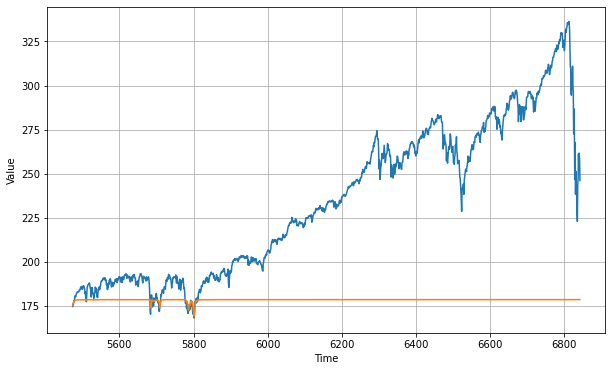

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [94]:
rnn_forecast_mae = mean_absolute_error(x_valid, rnn_forecast)

In [95]:
rnn_forecast_mae

59.44331024370549

### Seq to Seq RNN

#### Learning Rate

In [30]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [33]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100

# create windowed tensor data set from series
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1)
])


# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

optimizer = keras.optimizers.Nadam(lr=1e-7)


model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=125, callbacks=[lr_schedule])


Epoch 1/125
11/11 [==============================] - 3s 252ms/step - loss: 82.6512 - mae: 83.1512
Epoch 2/125
11/11 [==============================] - 3s 252ms/step - loss: 82.6497 - mae: 83.1497
Epoch 3/125
11/11 [==============================] - 3s 253ms/step - loss: 82.6477 - mae: 83.1477
Epoch 4/125
11/11 [==============================] - 3s 251ms/step - loss: 82.6454 - mae: 83.1454
Epoch 5/125
11/11 [==============================] - 3s 248ms/step - loss: 82.6428 - mae: 83.1428
Epoch 6/125
11/11 [==============================] - 3s 252ms/step - loss: 82.6399 - mae: 83.1399
Epoch 7/125
11/11 [==============================] - 3s 255ms/step - loss: 82.6367 - mae: 83.1366
Epoch 8/125
11/11 [==============================] - 3s 257ms/step - loss: 82.6330 - mae: 83.1330
Epoch 9/125
11/11 [==============================] - 3s 254ms/step - loss: 82.6289 - mae: 83.1289
Epoch 10/125
11/11 [==============================] - 3s 255ms/step - loss: 82.6242 - mae: 83.1242
Epoch 11/125
11/11 

11/11 [==============================] - 3s 255ms/step - loss: 55.4825 - mae: 55.9752
Epoch 84/125
11/11 [==============================] - 3s 253ms/step - loss: 53.8796 - mae: 54.3697
Epoch 85/125
11/11 [==============================] - 3s 250ms/step - loss: 52.3486 - mae: 52.8469
Epoch 86/125
11/11 [==============================] - 3s 253ms/step - loss: 50.7365 - mae: 51.2352
Epoch 87/125
11/11 [==============================] - 3s 253ms/step - loss: 49.0125 - mae: 49.5112
Epoch 88/125
11/11 [==============================] - 3s 249ms/step - loss: 47.1748 - mae: 47.6730
Epoch 89/125
11/11 [==============================] - 3s 257ms/step - loss: 45.2320 - mae: 45.7303
Epoch 90/125
11/11 [==============================] - 3s 252ms/step - loss: 43.1007 - mae: 43.5976
Epoch 91/125
11/11 [==============================] - 3s 260ms/step - loss: 40.7771 - mae: 41.2748
Epoch 92/125
11/11 [==============================] - 3s 254ms/step - loss: 39.3552 - mae: 39.8524
Epoch 93/125
11/11 [===

(1e-05, 1.0, 0.0, 50.0)

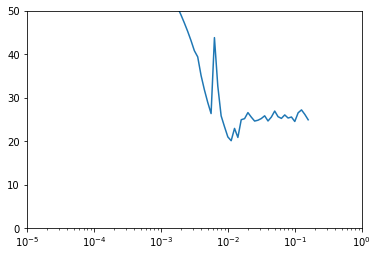

In [36]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 50])

#### Train Model

In [37]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 20

train_set = seq2seq_window_dataset(x_train, window_size, batch_size=512)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1)
])

# Set optimizer
optimizer = keras.optimizers.Nadam(lr=2e-3)

# compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=15)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
     11/Unknown - 1s 75ms/step - loss: 76.1288 - mae: 76.6288INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 3s 239ms/step - loss: 76.1288 - mae: 76.6288 - val_loss: 221.7142 - val_mae: 222.2142
Epoch 2/1000
11/11 [==============================] - 3s 254ms/step - loss: 69.3563 - mae: 69.8563 - val_loss: 218.1511 - val_mae: 218.6511
Epoch 3/1000
11/11 [==============================] - 2s 224ms/step - loss: 66.5565 - mae: 67.0564 - val_loss: 215.7412 - val_mae: 216.2412
Epoch 4/1000
11/11 [==============================] - 3s 232ms/step - loss: 64.1739 - mae: 64.6739 - val_loss: 213.3805 - val_mae: 213.8805
Epoch 5/1000
11/11 [==============================] - 3s 235ms/step - loss: 61.8221 - mae: 62.3221 - val_loss: 211.0406 - val_mae: 211.5406
Epoch 6/1000
11/11 [==============================] - 3s 237ms/step - loss: 59.4900 - mae: 59.9899 - val_loss: 208.7185 - val_mae: 209.2185
Epoch 7/1000
11/11 [=======================

Epoch 31/1000
11/11 [==============================] - 3s 235ms/step - loss: 21.5040 - mae: 21.9921 - val_loss: 162.0551 - val_mae: 162.5551
Epoch 32/1000
11/11 [==============================] - 3s 235ms/step - loss: 20.4520 - mae: 20.9390 - val_loss: 160.4530 - val_mae: 160.9530
Epoch 33/1000
11/11 [==============================] - 3s 283ms/step - loss: 19.3554 - mae: 19.8369 - val_loss: 158.8953 - val_mae: 159.3953
Epoch 34/1000
11/11 [==============================] - 3s 238ms/step - loss: 18.3355 - mae: 18.8117 - val_loss: 157.3566 - val_mae: 157.8565
Epoch 35/1000
11/11 [==============================] - 3s 237ms/step - loss: 17.5364 - mae: 18.0140 - val_loss: 155.8439 - val_mae: 156.3439
Epoch 36/1000
11/11 [==============================] - 3s 238ms/step - loss: 16.6339 - mae: 17.1129 - val_loss: 154.3760 - val_mae: 154.8760
Epoch 37/1000
11/11 [==============================] - 3s 236ms/step - loss: 15.9250 - mae: 16.3963 - val_loss: 152.9584 - val_mae: 153.4584
Epoch 38/1000

Epoch 61/1000
11/11 [==============================] - 3s 245ms/step - loss: 7.7096 - mae: 8.1679 - val_loss: 131.0936 - val_mae: 131.5937
Epoch 62/1000
11/11 [==============================] - 3s 246ms/step - loss: 7.5362 - mae: 7.9904 - val_loss: 130.4712 - val_mae: 130.9712
Epoch 63/1000
11/11 [==============================] - 3s 294ms/step - loss: 7.3864 - mae: 7.8420 - val_loss: 129.8890 - val_mae: 130.3889
Epoch 64/1000
11/11 [==============================] - 3s 247ms/step - loss: 7.3048 - mae: 7.7635 - val_loss: 129.2968 - val_mae: 129.7968
Epoch 65/1000
11/11 [==============================] - 3s 245ms/step - loss: 6.9739 - mae: 7.4154 - val_loss: 128.7350 - val_mae: 129.2350
Epoch 66/1000
11/11 [==============================] - 3s 244ms/step - loss: 6.8973 - mae: 7.3366 - val_loss: 128.2086 - val_mae: 128.7086
Epoch 67/1000
11/11 [==============================] - 3s 241ms/step - loss: 6.9171 - mae: 7.3714 - val_loss: 127.7807 - val_mae: 128.2807
Epoch 68/1000
11/11 [======

11/11 [==============================] - 3s 240ms/step - loss: 4.8328 - mae: 5.2527 - val_loss: 118.4910 - val_mae: 118.9910
Epoch 92/1000
11/11 [==============================] - 3s 241ms/step - loss: 4.7905 - mae: 5.2152 - val_loss: 118.1633 - val_mae: 118.6633
Epoch 93/1000
11/11 [==============================] - 3s 283ms/step - loss: 4.9577 - mae: 5.3945 - val_loss: 117.8435 - val_mae: 118.3435
Epoch 94/1000
11/11 [==============================] - 3s 244ms/step - loss: 4.8642 - mae: 5.3035 - val_loss: 117.5001 - val_mae: 118.0001
Epoch 95/1000
11/11 [==============================] - 3s 244ms/step - loss: 4.7324 - mae: 5.1648 - val_loss: 117.2351 - val_mae: 117.7351
Epoch 96/1000
11/11 [==============================] - 3s 244ms/step - loss: 4.5869 - mae: 5.0013 - val_loss: 116.9581 - val_mae: 117.4581
Epoch 97/1000
11/11 [==============================] - 3s 246ms/step - loss: 4.9380 - mae: 5.3805 - val_loss: 116.6427 - val_mae: 117.1427
Epoch 98/1000
11/11 [====================

11/11 [==============================] - 3s 250ms/step - loss: 3.8585 - mae: 4.2681 - val_loss: 110.1270 - val_mae: 110.6270
Epoch 122/1000
11/11 [==============================] - 3s 250ms/step - loss: 3.9887 - mae: 4.4107 - val_loss: 109.8913 - val_mae: 110.3913
Epoch 123/1000
11/11 [==============================] - 3s 299ms/step - loss: 3.9523 - mae: 4.3813 - val_loss: 109.5627 - val_mae: 110.0627
Epoch 124/1000
11/11 [==============================] - 3s 246ms/step - loss: 3.9579 - mae: 4.3921 - val_loss: 109.3456 - val_mae: 109.8457
Epoch 125/1000
11/11 [==============================] - 3s 244ms/step - loss: 3.7476 - mae: 4.1609 - val_loss: 109.0140 - val_mae: 109.5140
Epoch 126/1000
11/11 [==============================] - 3s 248ms/step - loss: 3.9460 - mae: 4.3769 - val_loss: 108.7861 - val_mae: 109.2860
Epoch 127/1000
11/11 [==============================] - 3s 249ms/step - loss: 3.4236 - mae: 3.8021 - val_loss: 108.4313 - val_mae: 108.9313
Epoch 128/1000
11/11 [=============

11/11 [==============================] - 3s 255ms/step - loss: 2.9966 - mae: 3.4172 - val_loss: 101.5063 - val_mae: 102.0063
Epoch 152/1000
11/11 [==============================] - 3s 250ms/step - loss: 2.9923 - mae: 3.4134 - val_loss: 101.3173 - val_mae: 101.8172
Epoch 153/1000
11/11 [==============================] - 3s 292ms/step - loss: 2.8012 - mae: 3.2130 - val_loss: 100.9996 - val_mae: 101.4996
Epoch 154/1000
11/11 [==============================] - 3s 248ms/step - loss: 2.8360 - mae: 3.2432 - val_loss: 100.7714 - val_mae: 101.2714
Epoch 155/1000
11/11 [==============================] - 3s 249ms/step - loss: 2.9410 - mae: 3.3663 - val_loss: 100.5101 - val_mae: 101.0101
Epoch 156/1000
11/11 [==============================] - 3s 249ms/step - loss: 2.7455 - mae: 3.1572 - val_loss: 100.2042 - val_mae: 100.7042
Epoch 157/1000
11/11 [==============================] - 3s 296ms/step - loss: 2.7119 - mae: 3.1155 - val_loss: 99.9906 - val_mae: 100.4906
Epoch 158/1000
11/11 [==============

11/11 [==============================] - 3s 250ms/step - loss: 2.2422 - mae: 2.6609 - val_loss: 93.6868 - val_mae: 94.1868
Epoch 182/1000
11/11 [==============================] - 3s 240ms/step - loss: 1.8993 - mae: 2.2798 - val_loss: 93.3083 - val_mae: 93.8083
Epoch 183/1000
11/11 [==============================] - 3s 288ms/step - loss: 2.2090 - mae: 2.6309 - val_loss: 93.1030 - val_mae: 93.6030
Epoch 184/1000
11/11 [==============================] - 3s 241ms/step - loss: 2.2104 - mae: 2.6343 - val_loss: 92.8364 - val_mae: 93.3364
Epoch 185/1000
11/11 [==============================] - 3s 241ms/step - loss: 2.0602 - mae: 2.4679 - val_loss: 92.5594 - val_mae: 93.0594
Epoch 186/1000
11/11 [==============================] - 3s 241ms/step - loss: 2.1814 - mae: 2.6054 - val_loss: 92.3637 - val_mae: 92.8637
Epoch 187/1000
11/11 [==============================] - 3s 250ms/step - loss: 2.0364 - mae: 2.4489 - val_loss: 92.0579 - val_mae: 92.5579
Epoch 188/1000
11/11 [===========================

11/11 [==============================] - 3s 245ms/step - loss: 1.7108 - mae: 2.1172 - val_loss: 86.7706 - val_mae: 87.2706
Epoch 212/1000
11/11 [==============================] - 3s 240ms/step - loss: 1.7773 - mae: 2.1944 - val_loss: 86.5897 - val_mae: 87.0897
Epoch 213/1000
11/11 [==============================] - 3s 283ms/step - loss: 1.4053 - mae: 1.7633 - val_loss: 86.3916 - val_mae: 86.8916
Epoch 214/1000
11/11 [==============================] - 3s 240ms/step - loss: 1.6963 - mae: 2.0928 - val_loss: 86.1874 - val_mae: 86.6874
Epoch 215/1000
11/11 [==============================] - 3s 243ms/step - loss: 1.7322 - mae: 2.1394 - val_loss: 85.9811 - val_mae: 86.4811
Epoch 216/1000
11/11 [==============================] - 3s 243ms/step - loss: 1.5732 - mae: 1.9715 - val_loss: 85.7650 - val_mae: 86.2650
Epoch 217/1000
11/11 [==============================] - 3s 243ms/step - loss: 1.6150 - mae: 2.0130 - val_loss: 85.6265 - val_mae: 86.1265
Epoch 218/1000
11/11 [===========================

11/11 [==============================] - 3s 247ms/step - loss: 1.4252 - mae: 1.8324 - val_loss: 81.0332 - val_mae: 81.5332
Epoch 242/1000
11/11 [==============================] - 3s 249ms/step - loss: 1.4806 - mae: 1.8919 - val_loss: 80.7716 - val_mae: 81.2716
Epoch 243/1000
11/11 [==============================] - 3s 302ms/step - loss: 1.4453 - mae: 1.8611 - val_loss: 80.6479 - val_mae: 81.1479
Epoch 244/1000
11/11 [==============================] - 3s 251ms/step - loss: 1.2620 - mae: 1.6447 - val_loss: 80.3392 - val_mae: 80.8392
Epoch 245/1000
11/11 [==============================] - 3s 247ms/step - loss: 1.1958 - mae: 1.5662 - val_loss: 80.1958 - val_mae: 80.6958
Epoch 246/1000
11/11 [==============================] - 3s 247ms/step - loss: 1.2672 - mae: 1.6390 - val_loss: 80.0042 - val_mae: 80.5042
Epoch 247/1000
11/11 [==============================] - 3s 251ms/step - loss: 1.3257 - mae: 1.7217 - val_loss: 79.7307 - val_mae: 80.2307
Epoch 248/1000
11/11 [===========================

11/11 [==============================] - 3s 249ms/step - loss: 1.2256 - mae: 1.6339 - val_loss: 75.7076 - val_mae: 76.2076
Epoch 272/1000
11/11 [==============================] - 3s 250ms/step - loss: 1.0757 - mae: 1.4643 - val_loss: 75.4569 - val_mae: 75.9569
Epoch 273/1000
11/11 [==============================] - 3s 294ms/step - loss: 1.1880 - mae: 1.5960 - val_loss: 75.4028 - val_mae: 75.9028
Epoch 274/1000
11/11 [==============================] - 3s 245ms/step - loss: 1.1055 - mae: 1.5034 - val_loss: 75.2372 - val_mae: 75.7373
Epoch 275/1000
11/11 [==============================] - 3s 240ms/step - loss: 1.0990 - mae: 1.4980 - val_loss: 75.1539 - val_mae: 75.6539
Epoch 276/1000
11/11 [==============================] - 3s 241ms/step - loss: 0.9013 - mae: 1.2572 - val_loss: 74.9880 - val_mae: 75.4880
Epoch 277/1000
11/11 [==============================] - 3s 240ms/step - loss: 1.0309 - mae: 1.4076 - val_loss: 74.7986 - val_mae: 75.2986
Epoch 278/1000
11/11 [===========================

11/11 [==============================] - 3s 250ms/step - loss: 1.0938 - mae: 1.5024 - val_loss: 71.6140 - val_mae: 72.1140
Epoch 302/1000
11/11 [==============================] - 3s 289ms/step - loss: 1.0884 - mae: 1.4950 - val_loss: 71.4845 - val_mae: 71.9845
Epoch 303/1000
11/11 [==============================] - 3s 243ms/step - loss: 1.0616 - mae: 1.4713 - val_loss: 71.4555 - val_mae: 71.9555
Epoch 304/1000
11/11 [==============================] - 3s 245ms/step - loss: 1.0107 - mae: 1.4126 - val_loss: 71.2348 - val_mae: 71.7348
Epoch 305/1000
11/11 [==============================] - 3s 244ms/step - loss: 1.0729 - mae: 1.4799 - val_loss: 71.2303 - val_mae: 71.7303
Epoch 306/1000
11/11 [==============================] - 3s 243ms/step - loss: 1.0219 - mae: 1.4205 - val_loss: 71.1489 - val_mae: 71.6489
Epoch 307/1000
11/11 [==============================] - 3s 247ms/step - loss: 0.9663 - mae: 1.3653 - val_loss: 70.9535 - val_mae: 71.4535
Epoch 308/1000
11/11 [===========================

11/11 [==============================] - 3s 245ms/step - loss: 0.8416 - mae: 1.2286 - val_loss: 68.5574 - val_mae: 69.0574
Epoch 333/1000
11/11 [==============================] - 3s 246ms/step - loss: 0.7187 - mae: 1.0754 - val_loss: 68.4813 - val_mae: 68.9813
Epoch 334/1000
11/11 [==============================] - 1s 109ms/step - loss: 0.9386 - mae: 1.3348 - val_loss: 68.4868 - val_mae: 68.9868
Epoch 335/1000
11/11 [==============================] - 3s 247ms/step - loss: 0.8582 - mae: 1.2411 - val_loss: 68.2534 - val_mae: 68.7534
Epoch 336/1000
11/11 [==============================] - 1s 114ms/step - loss: 0.7724 - mae: 1.1372 - val_loss: 68.2596 - val_mae: 68.7596
Epoch 337/1000
11/11 [==============================] - 3s 291ms/step - loss: 0.8945 - mae: 1.2929 - val_loss: 68.2057 - val_mae: 68.7057
Epoch 338/1000
11/11 [==============================] - 3s 248ms/step - loss: 0.8052 - mae: 1.1929 - val_loss: 67.9627 - val_mae: 68.4627
Epoch 339/1000
11/11 [===========================

Epoch 367/1000
11/11 [==============================] - 3s 247ms/step - loss: 0.8909 - mae: 1.2896 - val_loss: 65.7540 - val_mae: 66.2537
Epoch 368/1000
11/11 [==============================] - 1s 116ms/step - loss: 0.7742 - mae: 1.1545 - val_loss: 65.7658 - val_mae: 66.2658
Epoch 369/1000
11/11 [==============================] - 3s 252ms/step - loss: 0.7812 - mae: 1.1616 - val_loss: 65.6021 - val_mae: 66.1021
Epoch 370/1000
11/11 [==============================] - 3s 302ms/step - loss: 0.7414 - mae: 1.1029 - val_loss: 65.5653 - val_mae: 66.0651
Epoch 371/1000
11/11 [==============================] - 3s 255ms/step - loss: 0.8608 - mae: 1.2569 - val_loss: 65.5618 - val_mae: 66.0618
Epoch 372/1000
11/11 [==============================] - 3s 249ms/step - loss: 0.8040 - mae: 1.1962 - val_loss: 65.4221 - val_mae: 65.9221
Epoch 373/1000
11/11 [==============================] - 3s 250ms/step - loss: 0.8256 - mae: 1.2189 - val_loss: 65.4040 - val_mae: 65.9039
Epoch 374/1000
11/11 [============

11/11 [==============================] - 3s 250ms/step - loss: 0.7669 - mae: 1.1559 - val_loss: 63.4989 - val_mae: 63.9980
Epoch 401/1000
11/11 [==============================] - 3s 300ms/step - loss: 0.7147 - mae: 1.0996 - val_loss: 63.3290 - val_mae: 63.8286
Epoch 402/1000
11/11 [==============================] - 3s 248ms/step - loss: 0.7661 - mae: 1.1494 - val_loss: 63.3047 - val_mae: 63.8037
Epoch 403/1000
11/11 [==============================] - 3s 247ms/step - loss: 0.6713 - mae: 1.0445 - val_loss: 63.2461 - val_mae: 63.7457
Epoch 404/1000
11/11 [==============================] - 3s 250ms/step - loss: 0.6458 - mae: 1.0174 - val_loss: 63.1355 - val_mae: 63.6350
Epoch 405/1000
11/11 [==============================] - 1s 114ms/step - loss: 0.8268 - mae: 1.2271 - val_loss: 63.1729 - val_mae: 63.6726
Epoch 406/1000
11/11 [==============================] - 3s 289ms/step - loss: 0.7797 - mae: 1.1651 - val_loss: 63.0312 - val_mae: 63.5307
Epoch 407/1000
11/11 [===========================

11/11 [==============================] - 3s 302ms/step - loss: 0.6683 - mae: 1.0438 - val_loss: 61.2859 - val_mae: 61.7851
Epoch 435/1000
11/11 [==============================] - 1s 116ms/step - loss: 0.6331 - mae: 0.9932 - val_loss: 61.2982 - val_mae: 61.7970
Epoch 436/1000
11/11 [==============================] - 3s 248ms/step - loss: 0.6442 - mae: 1.0147 - val_loss: 61.2215 - val_mae: 61.7206
Epoch 437/1000
11/11 [==============================] - 3s 247ms/step - loss: 0.6218 - mae: 0.9889 - val_loss: 61.0720 - val_mae: 61.5714
Epoch 438/1000
11/11 [==============================] - 1s 116ms/step - loss: 0.7489 - mae: 1.1394 - val_loss: 61.1305 - val_mae: 61.6294
Epoch 439/1000
11/11 [==============================] - 3s 249ms/step - loss: 0.6791 - mae: 1.0582 - val_loss: 61.0336 - val_mae: 61.5329
Epoch 440/1000
11/11 [==============================] - 3s 242ms/step - loss: 0.5429 - mae: 0.8820 - val_loss: 61.0006 - val_mae: 61.4993
Epoch 441/1000
11/11 [===========================

11/11 [==============================] - 1s 113ms/step - loss: 0.6084 - mae: 0.9732 - val_loss: 59.8457 - val_mae: 60.3444
Epoch 471/1000
11/11 [==============================] - 3s 248ms/step - loss: 0.6052 - mae: 0.9757 - val_loss: 59.7459 - val_mae: 60.2451
Epoch 472/1000
11/11 [==============================] - 3s 283ms/step - loss: 0.5624 - mae: 0.9235 - val_loss: 59.6667 - val_mae: 60.1656
Epoch 473/1000
11/11 [==============================] - 1s 113ms/step - loss: 0.6644 - mae: 1.0465 - val_loss: 59.7655 - val_mae: 60.2642
Epoch 474/1000
11/11 [==============================] - 3s 245ms/step - loss: 0.5833 - mae: 0.9335 - val_loss: 59.6196 - val_mae: 60.1185
Epoch 475/1000
11/11 [==============================] - 3s 245ms/step - loss: 0.5822 - mae: 0.9376 - val_loss: 59.6144 - val_mae: 60.1136
Epoch 476/1000
11/11 [==============================] - 1s 113ms/step - loss: 0.6864 - mae: 1.0753 - val_loss: 59.6335 - val_mae: 60.1321
Epoch 477/1000
11/11 [===========================

11/11 [==============================] - 1s 115ms/step - loss: 0.5652 - mae: 0.9343 - val_loss: 58.7602 - val_mae: 59.2592
Epoch 510/1000
11/11 [==============================] - 3s 291ms/step - loss: 0.5969 - mae: 0.9485 - val_loss: 58.6632 - val_mae: 59.1615
Epoch 511/1000
11/11 [==============================] - 1s 111ms/step - loss: 0.5583 - mae: 0.8943 - val_loss: 58.6676 - val_mae: 59.1669
Epoch 512/1000
11/11 [==============================] - 1s 111ms/step - loss: 0.7007 - mae: 1.0916 - val_loss: 58.7013 - val_mae: 59.2008
Epoch 513/1000
11/11 [==============================] - 3s 244ms/step - loss: 0.6920 - mae: 1.0854 - val_loss: 58.6131 - val_mae: 59.1114
Epoch 514/1000
11/11 [==============================] - 1s 111ms/step - loss: 0.6560 - mae: 1.0369 - val_loss: 58.6175 - val_mae: 59.1170
Epoch 515/1000
11/11 [==============================] - 3s 246ms/step - loss: 0.5017 - mae: 0.8411 - val_loss: 58.5236 - val_mae: 59.0218
Epoch 516/1000
11/11 [===========================

11/11 [==============================] - 3s 242ms/step - loss: 0.5681 - mae: 0.9134 - val_loss: 57.8931 - val_mae: 58.3896
Epoch 554/1000
11/11 [==============================] - 1s 108ms/step - loss: 0.5653 - mae: 0.9107 - val_loss: 57.9620 - val_mae: 58.4608
Epoch 555/1000
11/11 [==============================] - 1s 107ms/step - loss: 0.6221 - mae: 1.0058 - val_loss: 57.9141 - val_mae: 58.4124
Epoch 556/1000
11/11 [==============================] - 3s 243ms/step - loss: 0.5464 - mae: 0.9117 - val_loss: 57.8790 - val_mae: 58.3756
Epoch 557/1000
11/11 [==============================] - 1s 106ms/step - loss: 0.5609 - mae: 0.9278 - val_loss: 57.9431 - val_mae: 58.4420
Epoch 558/1000
11/11 [==============================] - 1s 107ms/step - loss: 0.4876 - mae: 0.8224 - val_loss: 57.8807 - val_mae: 58.3793
Epoch 559/1000
11/11 [==============================] - 3s 243ms/step - loss: 0.5398 - mae: 0.9032 - val_loss: 57.8615 - val_mae: 58.3580
Epoch 560/1000
11/11 [===========================

Epoch 599/1000
11/11 [==============================] - 1s 114ms/step - loss: 0.5876 - mae: 0.9624 - val_loss: 57.5829 - val_mae: 58.0820
Epoch 600/1000
11/11 [==============================] - 1s 119ms/step - loss: 0.5603 - mae: 0.9171 - val_loss: 57.4966 - val_mae: 57.9936
Epoch 601/1000
11/11 [==============================] - 1s 118ms/step - loss: 0.5454 - mae: 0.8981 - val_loss: 57.5503 - val_mae: 58.0491
Epoch 602/1000
11/11 [==============================] - 1s 117ms/step - loss: 0.6371 - mae: 1.0108 - val_loss: 57.5529 - val_mae: 58.0513
Epoch 603/1000
11/11 [==============================] - 3s 260ms/step - loss: 0.5859 - mae: 0.9638 - val_loss: 57.4565 - val_mae: 57.9533
Epoch 604/1000
11/11 [==============================] - 1s 120ms/step - loss: 0.6281 - mae: 1.0123 - val_loss: 57.6367 - val_mae: 58.1355
Epoch 605/1000
11/11 [==============================] - 1s 115ms/step - loss: 0.5830 - mae: 0.9349 - val_loss: 57.4835 - val_mae: 57.9800
Epoch 606/1000
11/11 [============

Epoch 650/1000
11/11 [==============================] - 1s 113ms/step - loss: 0.5117 - mae: 0.8460 - val_loss: 57.0873 - val_mae: 57.5840
Epoch 651/1000
11/11 [==============================] - 3s 253ms/step - loss: 0.4566 - mae: 0.7866 - val_loss: 57.0197 - val_mae: 57.5172
Epoch 652/1000
11/11 [==============================] - 1s 117ms/step - loss: 0.4939 - mae: 0.8278 - val_loss: 57.0871 - val_mae: 57.5857
Epoch 653/1000
11/11 [==============================] - 3s 302ms/step - loss: 0.5280 - mae: 0.8730 - val_loss: 57.0077 - val_mae: 57.5055
Epoch 654/1000
11/11 [==============================] - 3s 255ms/step - loss: 0.5006 - mae: 0.8321 - val_loss: 56.9566 - val_mae: 57.4547
Epoch 655/1000
11/11 [==============================] - 1s 124ms/step - loss: 0.5293 - mae: 0.8726 - val_loss: 56.9731 - val_mae: 57.4696
Epoch 656/1000
11/11 [==============================] - 3s 259ms/step - loss: 0.5290 - mae: 0.8891 - val_loss: 56.8684 - val_mae: 57.3659
Epoch 657/1000
11/11 [============

Epoch 700/1000
11/11 [==============================] - 1s 115ms/step - loss: 0.5066 - mae: 0.8484 - val_loss: 56.8348 - val_mae: 57.3317
Epoch 701/1000
11/11 [==============================] - 1s 115ms/step - loss: 0.5782 - mae: 0.9505 - val_loss: 56.7813 - val_mae: 57.2775
Epoch 702/1000
11/11 [==============================] - 3s 253ms/step - loss: 0.5139 - mae: 0.8725 - val_loss: 56.7475 - val_mae: 57.2456
Epoch 703/1000
11/11 [==============================] - 1s 106ms/step - loss: 0.5527 - mae: 0.9204 - val_loss: 56.8261 - val_mae: 57.3242
Epoch 704/1000
11/11 [==============================] - 1s 105ms/step - loss: 0.5253 - mae: 0.8689 - val_loss: 56.7726 - val_mae: 57.2710
Epoch 705/1000
11/11 [==============================] - 1s 107ms/step - loss: 0.5171 - mae: 0.8603 - val_loss: 56.7509 - val_mae: 57.2469
Epoch 706/1000
11/11 [==============================] - 1s 105ms/step - loss: 0.5699 - mae: 0.9447 - val_loss: 56.8173 - val_mae: 57.3133
Epoch 707/1000
11/11 [============

Epoch 746/1000
11/11 [==============================] - 3s 247ms/step - loss: 0.4375 - mae: 0.7728 - val_loss: 56.4934 - val_mae: 56.9916
Epoch 747/1000
11/11 [==============================] - 1s 109ms/step - loss: 0.4324 - mae: 0.7609 - val_loss: 56.5225 - val_mae: 57.0196
Epoch 748/1000
11/11 [==============================] - 1s 108ms/step - loss: 0.5403 - mae: 0.8973 - val_loss: 56.6105 - val_mae: 57.1084
Epoch 749/1000
11/11 [==============================] - 3s 240ms/step - loss: 0.5046 - mae: 0.8572 - val_loss: 56.4611 - val_mae: 56.9591
Epoch 750/1000
11/11 [==============================] - 1s 112ms/step - loss: 0.5868 - mae: 0.9465 - val_loss: 56.5363 - val_mae: 57.0326
Epoch 751/1000
11/11 [==============================] - 1s 112ms/step - loss: 0.4856 - mae: 0.8260 - val_loss: 56.5086 - val_mae: 57.0056
Epoch 752/1000
11/11 [==============================] - 1s 112ms/step - loss: 0.4628 - mae: 0.8059 - val_loss: 56.5039 - val_mae: 57.0008
Epoch 753/1000
11/11 [============

#### Make Predictions

In [64]:
model = keras.models.load_model("my_checkpoint")

In [95]:
rnn_forecast = model_forecast(model, spy['Adj Close'].values[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [96]:
x_valid.shape, rnn_forecast.shape

((1369,), (1369,))

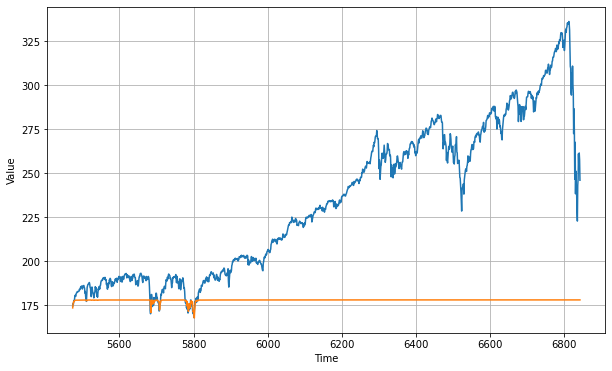

In [97]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

### Seq to Seq RNN on Stationary Data

#### Data

In [193]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# All values normalized to training data
spy_noramlized_to_traindata = x_train_scaler.transform(spy['Adj Close'].values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

#### Learning Rate Finder

In [194]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100

# create windowed tensor data set from series
train_set = window_dataset(normalized_x_train, window_size, batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])


# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = keras.optimizers.Nadam(lr=1e-7)


model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
11/11 [==============================] - 3s 293ms/step - loss: 0.1073 - mae: 0.3888
Epoch 2/100
11/11 [==============================] - 3s 290ms/step - loss: 0.0693 - mae: 0.2949
Epoch 3/100
11/11 [==============================] - 3s 291ms/step - loss: 0.0456 - mae: 0.2227
Epoch 4/100
11/11 [==============================] - 3s 290ms/step - loss: 0.0335 - mae: 0.1823
Epoch 5/100
11/11 [==============================] - 3s 290ms/step - loss: 0.0273 - mae: 0.1628
Epoch 6/100
11/11 [==============================] - 3s 293ms/step - loss: 0.0224 - mae: 0.1449
Epoch 7/100
11/11 [==============================] - 3s 289ms/step - loss: 0.0180 - mae: 0.1264
Epoch 8/100
11/11 [==============================] - 3s 291ms/step - loss: 0.0148 - mae: 0.1144
Epoch 9/100
11/11 [==============================] - 3s 290ms/step - loss: 0.0125 - mae: 0.1064
Epoch 10/100
11/11 [==============================] - 3s 294ms/step - loss: 0.0107 - mae: 0.0989
Epoch 11/100
11/11 [===================

11/11 [==============================] - 3s 293ms/step - loss: 6.1748 - mae: 6.6748
Epoch 86/100
11/11 [==============================] - 3s 300ms/step - loss: 6.8661 - mae: 7.3661
Epoch 87/100
11/11 [==============================] - 3s 293ms/step - loss: 7.6305 - mae: 8.1305
Epoch 88/100
11/11 [==============================] - 3s 300ms/step - loss: 8.4774 - mae: 8.9774
Epoch 89/100
11/11 [==============================] - 3s 295ms/step - loss: 9.4182 - mae: 9.9182
Epoch 90/100
11/11 [==============================] - 3s 297ms/step - loss: 10.4940 - mae: 10.9940
Epoch 91/100
11/11 [==============================] - 3s 298ms/step - loss: 11.7265 - mae: 12.2265
Epoch 92/100
11/11 [==============================] - 3s 297ms/step - loss: 12.9643 - mae: 13.4643
Epoch 93/100
11/11 [==============================] - 3s 299ms/step - loss: 14.5070 - mae: 15.0070
Epoch 94/100
11/11 [==============================] - 3s 306ms/step - loss: 16.1252 - mae: 16.6252
Epoch 95/100
11/11 [=============

(1e-07, 1.0, 0.0, 0.05)

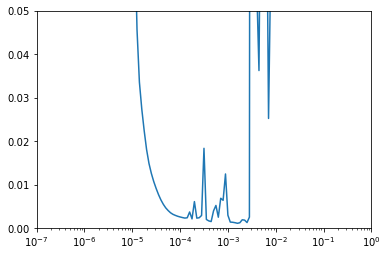

In [195]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, .05])

#### Train Model

In [196]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100
train_set = window_dataset(normalized_x_train, window_size, batch_size=512)
valid_set = window_dataset(normalized_x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])

# Set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-4)

#compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
     11/Unknown - 3s 291ms/step - loss: 0.0598 - mae: 0.2423INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 5s 479ms/step - loss: 0.0598 - mae: 0.2423 - val_loss: 0.7404 - val_mae: 1.2170
Epoch 2/1000
11/11 [==============================] - 5s 467ms/step - loss: 0.0243 - mae: 0.1588 - val_loss: 0.4383 - val_mae: 0.8724
Epoch 3/1000
11/11 [==============================] - 5s 466ms/step - loss: 0.0121 - mae: 0.1079 - val_loss: 0.2881 - val_mae: 0.6829
Epoch 4/1000
11/11 [==============================] - 6s 528ms/step - loss: 0.0075 - mae: 0.0837 - val_loss: 0.2151 - val_mae: 0.5810
Epoch 5/1000
11/11 [==============================] - 5s 480ms/step - loss: 0.0053 - mae: 0.0699 - val_loss: 0.1703 - val_mae: 0.5093
Epoch 6/1000
11/11 [==============================] - 5s 476ms/step - loss: 0.0042 - mae: 0.0613 - val_loss: 0.1430 - val_mae: 0.4618
Epoch 7/1000
11/11 [==============================] - 5s 469ms/step - loss: 0.00

11/11 [==============================] - 5s 450ms/step - loss: 9.9552e-04 - mae: 0.0311 - val_loss: 0.0156 - val_mae: 0.1294
Epoch 44/1000
11/11 [==============================] - 4s 321ms/step - loss: 9.6856e-04 - mae: 0.0305 - val_loss: 0.0168 - val_mae: 0.1365
Epoch 45/1000
11/11 [==============================] - 3s 317ms/step - loss: 0.0011 - mae: 0.0328 - val_loss: 0.0263 - val_mae: 0.1926
Epoch 46/1000
11/11 [==============================] - 3s 314ms/step - loss: 9.8252e-04 - mae: 0.0316 - val_loss: 0.0161 - val_mae: 0.1333
Epoch 47/1000
11/11 [==============================] - 5s 457ms/step - loss: 0.0010 - mae: 0.0319 - val_loss: 0.0126 - val_mae: 0.1156
Epoch 48/1000
11/11 [==============================] - 4s 323ms/step - loss: 0.0010 - mae: 0.0320 - val_loss: 0.0161 - val_mae: 0.1345
Epoch 49/1000
11/11 [==============================] - 4s 320ms/step - loss: 9.2686e-04 - mae: 0.0299 - val_loss: 0.0143 - val_mae: 0.1242
Epoch 50/1000
11/11 [==============================] 

11/11 [==============================] - 4s 324ms/step - loss: 8.8912e-04 - mae: 0.0308 - val_loss: 0.0073 - val_mae: 0.0878
Epoch 90/1000
11/11 [==============================] - 4s 320ms/step - loss: 8.8530e-04 - mae: 0.0305 - val_loss: 0.0084 - val_mae: 0.0935
Epoch 91/1000
11/11 [==============================] - 4s 319ms/step - loss: 8.0962e-04 - mae: 0.0281 - val_loss: 0.0080 - val_mae: 0.0908
Epoch 92/1000
11/11 [==============================] - 4s 320ms/step - loss: 8.3019e-04 - mae: 0.0286 - val_loss: 0.0073 - val_mae: 0.0867
Epoch 93/1000
11/11 [==============================] - 4s 322ms/step - loss: 8.3539e-04 - mae: 0.0288 - val_loss: 0.0098 - val_mae: 0.1060
Epoch 94/1000
11/11 [==============================] - 4s 321ms/step - loss: 8.0970e-04 - mae: 0.0282 - val_loss: 0.0090 - val_mae: 0.0987
Epoch 95/1000
11/11 [==============================] - 4s 321ms/step - loss: 8.1496e-04 - mae: 0.0282 - val_loss: 0.0079 - val_mae: 0.0905
Epoch 96/1000
11/11 [====================

Epoch 138/1000
11/11 [==============================] - 4s 324ms/step - loss: 8.3280e-04 - mae: 0.0289 - val_loss: 0.0064 - val_mae: 0.0806
Epoch 139/1000
11/11 [==============================] - 5s 453ms/step - loss: 7.9026e-04 - mae: 0.0278 - val_loss: 0.0056 - val_mae: 0.0758
Epoch 140/1000
11/11 [==============================] - 4s 322ms/step - loss: 8.0535e-04 - mae: 0.0283 - val_loss: 0.0059 - val_mae: 0.0769
Epoch 141/1000
11/11 [==============================] - 4s 320ms/step - loss: 7.8611e-04 - mae: 0.0275 - val_loss: 0.0064 - val_mae: 0.0814
Epoch 142/1000
11/11 [==============================] - 5s 454ms/step - loss: 7.9400e-04 - mae: 0.0277 - val_loss: 0.0055 - val_mae: 0.0755
Epoch 143/1000
11/11 [==============================] - 4s 323ms/step - loss: 8.4470e-04 - mae: 0.0292 - val_loss: 0.0060 - val_mae: 0.0834
Epoch 144/1000
11/11 [==============================] - 4s 323ms/step - loss: 9.2286e-04 - mae: 0.0312 - val_loss: 0.0066 - val_mae: 0.0905
Epoch 145/1000
11/11

Epoch 187/1000
11/11 [==============================] - 4s 330ms/step - loss: 7.9883e-04 - mae: 0.0280 - val_loss: 0.0058 - val_mae: 0.0774
Epoch 188/1000
11/11 [==============================] - 5s 465ms/step - loss: 7.7384e-04 - mae: 0.0272 - val_loss: 0.0050 - val_mae: 0.0702
Epoch 189/1000
11/11 [==============================] - 4s 329ms/step - loss: 7.9256e-04 - mae: 0.0278 - val_loss: 0.0065 - val_mae: 0.0854
Epoch 190/1000
11/11 [==============================] - 4s 335ms/step - loss: 7.8524e-04 - mae: 0.0277 - val_loss: 0.0058 - val_mae: 0.0782
Epoch 191/1000
11/11 [==============================] - 4s 328ms/step - loss: 7.8809e-04 - mae: 0.0277 - val_loss: 0.0051 - val_mae: 0.0735
Epoch 192/1000
11/11 [==============================] - 4s 333ms/step - loss: 8.1024e-04 - mae: 0.0287 - val_loss: 0.0051 - val_mae: 0.0731
Epoch 193/1000
11/11 [==============================] - 5s 467ms/step - loss: 7.8950e-04 - mae: 0.0278 - val_loss: 0.0049 - val_mae: 0.0700
Epoch 194/1000
11/11

Epoch 237/1000
11/11 [==============================] - 4s 324ms/step - loss: 7.8332e-04 - mae: 0.0275 - val_loss: 0.0047 - val_mae: 0.0691
Epoch 238/1000
11/11 [==============================] - 5s 456ms/step - loss: 7.7622e-04 - mae: 0.0274 - val_loss: 0.0047 - val_mae: 0.0676
Epoch 239/1000
11/11 [==============================] - 4s 324ms/step - loss: 7.7762e-04 - mae: 0.0274 - val_loss: 0.0052 - val_mae: 0.0722
Epoch 240/1000
11/11 [==============================] - 4s 336ms/step - loss: 8.1814e-04 - mae: 0.0282 - val_loss: 0.0060 - val_mae: 0.0844
Epoch 241/1000
11/11 [==============================] - 4s 330ms/step - loss: 8.4942e-04 - mae: 0.0296 - val_loss: 0.0052 - val_mae: 0.0723
Epoch 242/1000
11/11 [==============================] - 5s 459ms/step - loss: 7.7504e-04 - mae: 0.0274 - val_loss: 0.0046 - val_mae: 0.0670
Epoch 243/1000
11/11 [==============================] - 4s 328ms/step - loss: 7.7688e-04 - mae: 0.0275 - val_loss: 0.0048 - val_mae: 0.0694
Epoch 244/1000
11/11

11/11 [==============================] - 4s 329ms/step - loss: 8.2365e-04 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0697
Epoch 289/1000
11/11 [==============================] - 4s 328ms/step - loss: 7.6956e-04 - mae: 0.0270 - val_loss: 0.0045 - val_mae: 0.0665
Epoch 290/1000
11/11 [==============================] - 4s 325ms/step - loss: 8.0993e-04 - mae: 0.0280 - val_loss: 0.0058 - val_mae: 0.0822
Epoch 291/1000
11/11 [==============================] - 4s 327ms/step - loss: 8.1719e-04 - mae: 0.0286 - val_loss: 0.0056 - val_mae: 0.0799
Epoch 292/1000
11/11 [==============================] - 4s 326ms/step - loss: 7.8349e-04 - mae: 0.0276 - val_loss: 0.0047 - val_mae: 0.0688
Epoch 293/1000
11/11 [==============================] - 5s 459ms/step - loss: 7.6875e-04 - mae: 0.0270 - val_loss: 0.0045 - val_mae: 0.0654
Epoch 294/1000
11/11 [==============================] - 4s 327ms/step - loss: 7.8848e-04 - mae: 0.0275 - val_loss: 0.0052 - val_mae: 0.0755
Epoch 295/1000
11/11 [=============

Epoch 342/1000
11/11 [==============================] - 4s 328ms/step - loss: 8.0183e-04 - mae: 0.0282 - val_loss: 0.0046 - val_mae: 0.0675
Epoch 343/1000
11/11 [==============================] - 4s 331ms/step - loss: 7.6922e-04 - mae: 0.0270 - val_loss: 0.0048 - val_mae: 0.0703
Epoch 344/1000
11/11 [==============================] - 4s 334ms/step - loss: 7.8128e-04 - mae: 0.0276 - val_loss: 0.0051 - val_mae: 0.0742
Epoch 345/1000
11/11 [==============================] - 4s 329ms/step - loss: 7.7546e-04 - mae: 0.0274 - val_loss: 0.0044 - val_mae: 0.0645
Epoch 346/1000
11/11 [==============================] - 4s 326ms/step - loss: 7.5610e-04 - mae: 0.0268 - val_loss: 0.0044 - val_mae: 0.0647
Epoch 347/1000
11/11 [==============================] - 4s 331ms/step - loss: 7.6268e-04 - mae: 0.0269 - val_loss: 0.0044 - val_mae: 0.0639
Epoch 348/1000
11/11 [==============================] - 4s 325ms/step - loss: 7.5507e-04 - mae: 0.0267 - val_loss: 0.0044 - val_mae: 0.0649
Epoch 349/1000
11/11

In [197]:
model = keras.models.load_model("my_checkpoint")

#### Make Predictions

In [207]:
rnn_forecast = model_forecast(model, spy_noramlized_to_traindata, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [208]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast

array([174.98914, 176.7272 , 177.7629 , ..., 255.76485, 264.8034 ,
       259.15506], dtype=float32)

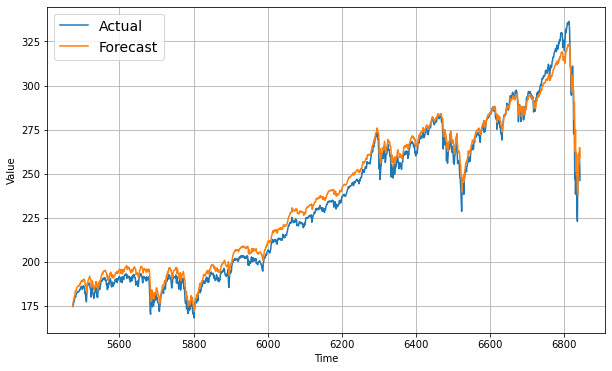

In [210]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Actual")
plot_series(time_valid, rnn_unscaled_forecast, label="Forecast")


In [212]:
# Alternative way to show MAE to stay consistent with what we will be doing later
rnn_mae = keras.metrics.mean_absolute_error(x_valid, rnn_unscaled_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['rnn_mae'] = rnn_mae
model_mae_scores

NameError: name 'model_mae_scores' is not defined

# LSTM Model

# CNN - Wavenet Model